In [58]:
import numpy as np
%load_ext autoreload
%autoreload 2
import pandas as pd
from helpers.training import *
from helpers.visualizations import *
from helpers.preprocessing import *
from helpers.aequitas_methods import *
from helpers.mitigation_methods import *
from aequitas.flow.methods.inprocessing import FairlearnClassifier
from sklearn.metrics import classification_report
from IPython.display import display, HTML
from aequitas import Audit
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import openml
import warnings
import math
warnings.filterwarnings(action='ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
ml_ds = openml.datasets.get_dataset(43904)
df, * _ = ml_ds.get_data()
print(ml_ds.description[:500])
target = "bar"

Law School Admissions (Binarized) 
 Survey among students attending law school in the U.S. in 1991. 
 The dataset was obtained from the R-package fairml. 
 The response variable has been changed to a binary version: Whether ugpa is greater than 3.
 The race1 variables has been binarized to labels white and non-white.


In [34]:
df

age  decile1  decile3  fam_inc  lsat  gender  race1 cluster fulltime  \
0       62       10       10        5  44.0  female  white       1        1   
1       62        5        4        4  29.0  female  white       2        1   
2       61        8        7        3  37.0    male  white       1        1   
3       60        8        7        4  43.0  female  white       1        1   
4       57        3        2        4  41.0  female  white       4        1   
...    ...      ...      ...      ...   ...     ...    ...     ...      ...   
20795   60        9        8        4  42.0    male  white       5        1   
20796   61        4        9        4  29.5    male  white       3        1   
20797   62        1        1        3  33.0    male  black       3        1   
20798   65        4        5        3  32.0    male  white       3        2   
20799   60        9        3        3  36.0    male  other       4        1   

         bar  ugpagt3  
0       True     True  
1       True     True  
2       True     True  
3       True     True  
4       True     True  
...      ...      ...  
20795   True    False  
20796   True     True  
20797  False     True  
20798   True    False  
20799   True     True  

[20800 rows x 11 columns]

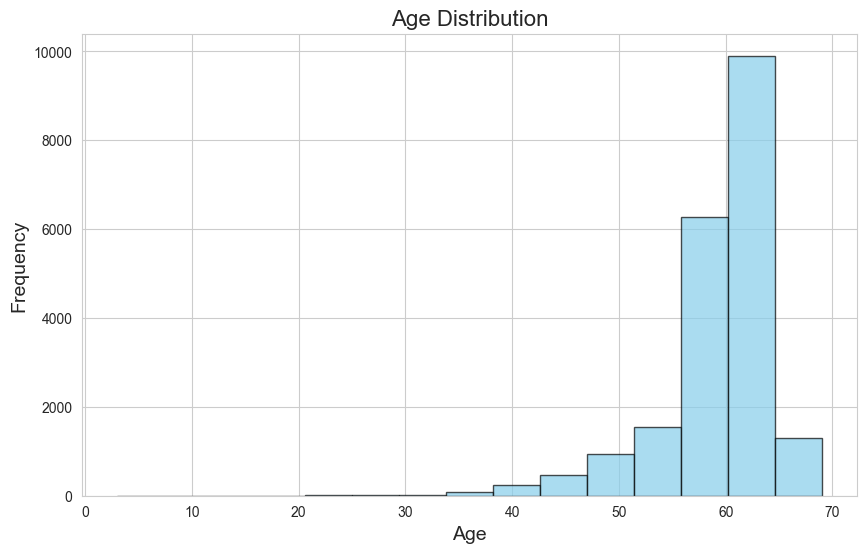

In [35]:
plt.figure(figsize=(10, 6))
plt.hist(df['age'], bins=15, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Age Distribution', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

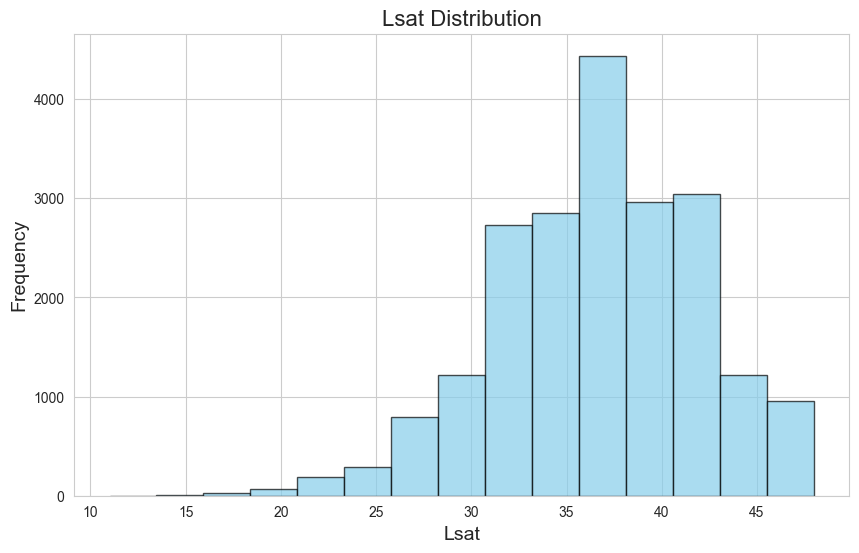

In [36]:
plt.figure(figsize=(10, 6))
plt.hist(df['lsat'], bins=15, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Lsat Distribution', fontsize=16)
plt.xlabel('Lsat', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

In [64]:
protected_attributes = ["race","fam_inc","lsat"]
def categorize_age(age):
    if age<60:
        return '0'
    if age>=60:
        return '1'
def categorize_lsat(lsat):
    if lsat<35:
        return '0'
    if lsat>=35:
        return '1'
df["age"] = df["age"].apply(categorize_age)
df["lsat"] = df["lsat"].apply(categorize_lsat)

df.rename(columns={ 'race1':'race'}, inplace=True)
df['race'].replace('black','other',inplace=True)
df['race'].replace('hisp','other',inplace=True)
df['race'].replace('asian','other',inplace=True)

In [65]:
df["lsat"].value_counts(normalize=True) * 100

1    67.567308
0    32.432692
Name: lsat, dtype: float64

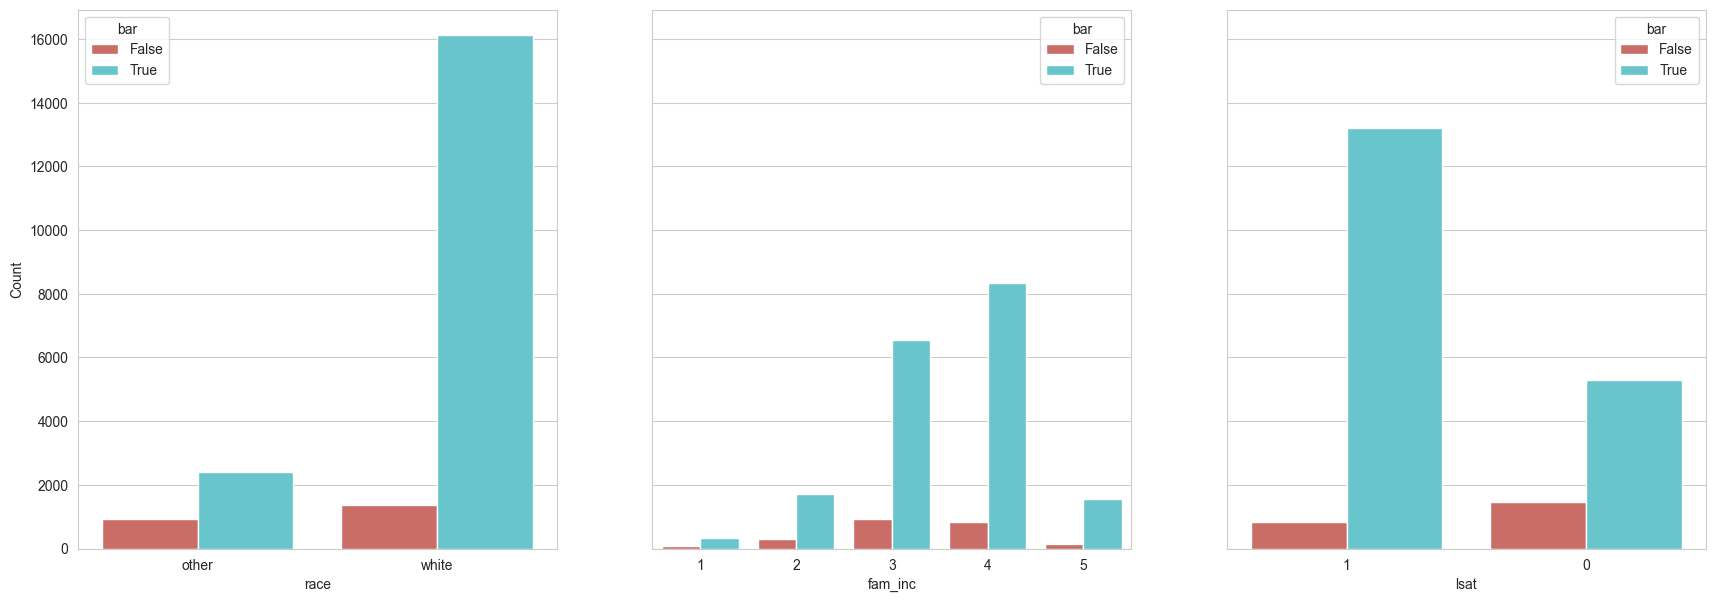

In [66]:
def plot_attributes(dataset,attributes):
    fontsize = 10
    num_elements = len(attributes)
    num_cols = min(3, num_elements)  
    num_rows = math.ceil(num_elements / num_cols)
    
    fig_width = 7 * num_cols
    fig_height = 7 * num_rows
    
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height), sharey=True, gridspec_kw={'hspace':0.5})
    ax = ax.flatten()
    plt.subplots_adjust(hspace = 1.5)
    sns.set_style("whitegrid")
    for i, attribute in enumerate(attributes):
        g0 = sns.countplot(x=attribute, data=dataset, palette="hls", 
                      ax=ax[i],hue=target) # order=dataset[attribute].value_counts().index)
        g0.set_xlabel(attribute, fontsize=fontsize)
        g0.set_ylabel("Count", fontsize=fontsize)
plot_attributes(df,protected_attributes)

In [67]:
categorical_attributes = get_categorical_attributes(df)
df[target] = df[target].astype(int)
df_num = df.copy()
encode_categorical_attributes(df_num, categorical_attributes)
scaler = MinMaxScaler()

for col in df_num.columns:
    if col not in categorical_attributes and col != target and col not in protected_attributes:
        df_num[col] = scaler.fit_transform(df_num[[col]])
df_num["fam_inc"] = df_num["fam_inc"].astype(int)

['age', 'lsat', 'gender', 'race', 'cluster', 'fulltime']
Attribute: age
{'0': 0, '1': 1}
Attribute: lsat
{'0': 0, '1': 1}
Attribute: gender
{'female': 0, 'male': 1}
Attribute: race
{'other': 0, 'white': 1}
Attribute: cluster
{'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5}
Attribute: fulltime
{'1': 0, '2': 1}


<Axes: >

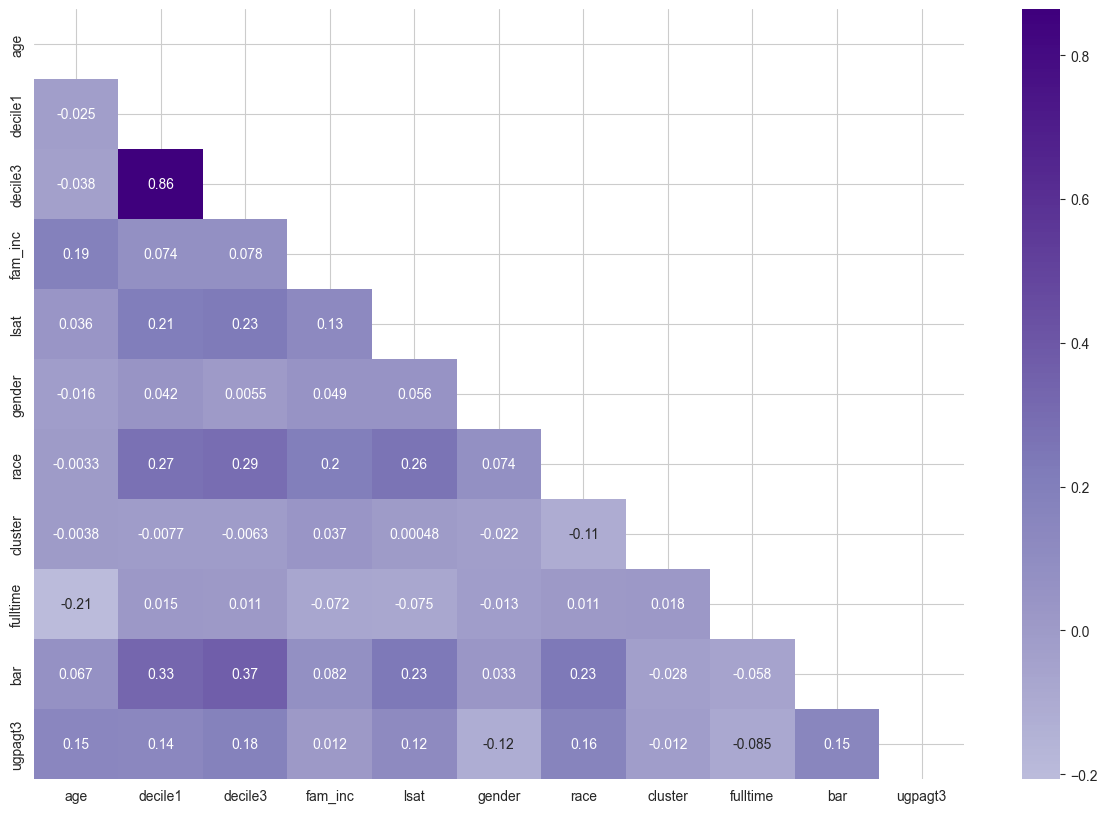

In [68]:
corr = df_num.corr()
below_main_diagonal = corr.where(np.tril(np.ones(corr.shape), k=-1).astype(bool))
mask = pd.isna(below_main_diagonal) 
plt.figure(figsize=(15, 10))
sns.heatmap(below_main_diagonal.fillna(0),
            annot=True, 
            cmap="Purples",
            center=0, 
            mask=mask,
            vmin=below_main_diagonal.min().min(), 
            vmax=below_main_diagonal.max().max()
            )

In [70]:
'''
Top 3 protected attributes: "race","age","lsat". Create new dataset with new columns containing the intersection of these attributes. Convert them to numerical.
'''
df_intersect = df.copy()
df_intersect["race/fam_inc"] = df_intersect["race"].astype(str) + " " +  df_intersect["fam_inc"].astype(str)
df_intersect["race/lsat"] = df_intersect["race"].astype(str) + " " + df_intersect["lsat"].astype(str)
df_intersect["lsat/fam_inc"] = df_intersect["lsat"].astype(str) + " " + df_intersect["fam_inc"].astype(str)

df_intersect.drop(["race", "lsat", "fam_inc"], axis=1, inplace=True)

categorical_attributes = get_categorical_attributes(df_intersect)
df_num_int = df_intersect.copy()
encode_categorical_attributes(df_num_int, categorical_attributes)
# scaler = MinMaxScaler()
# 
# for col in df_num_int.columns:
#     if col not in categorical_attributes and col != target and col not in protected_attributes:
#         df_num_int[col] = scaler.fit_transform(df_num_int[[col]])
protected_attributes_int = ["race/fam_inc","race/lsat","lsat/fam_inc"]

['age', 'gender', 'cluster', 'fulltime', 'race/fam_inc', 'race/lsat', 'lsat/fam_inc']
Attribute: age
{'0': 0, '1': 1}
Attribute: gender
{'female': 0, 'male': 1}
Attribute: cluster
{'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5}
Attribute: fulltime
{'1': 0, '2': 1}
Attribute: race/fam_inc
{'other 1': 0, 'other 2': 1, 'other 3': 2, 'other 4': 3, 'other 5': 4, 'white 1': 5, 'white 2': 6, 'white 3': 7, 'white 4': 8, 'white 5': 9}
Attribute: race/lsat
{'other 0': 0, 'other 1': 1, 'white 0': 2, 'white 1': 3}
Attribute: lsat/fam_inc
{'0 1': 0, '0 2': 1, '0 3': 2, '0 4': 3, '0 5': 4, '1 1': 5, '1 2': 6, '1 3': 7, '1 4': 8, '1 5': 9}


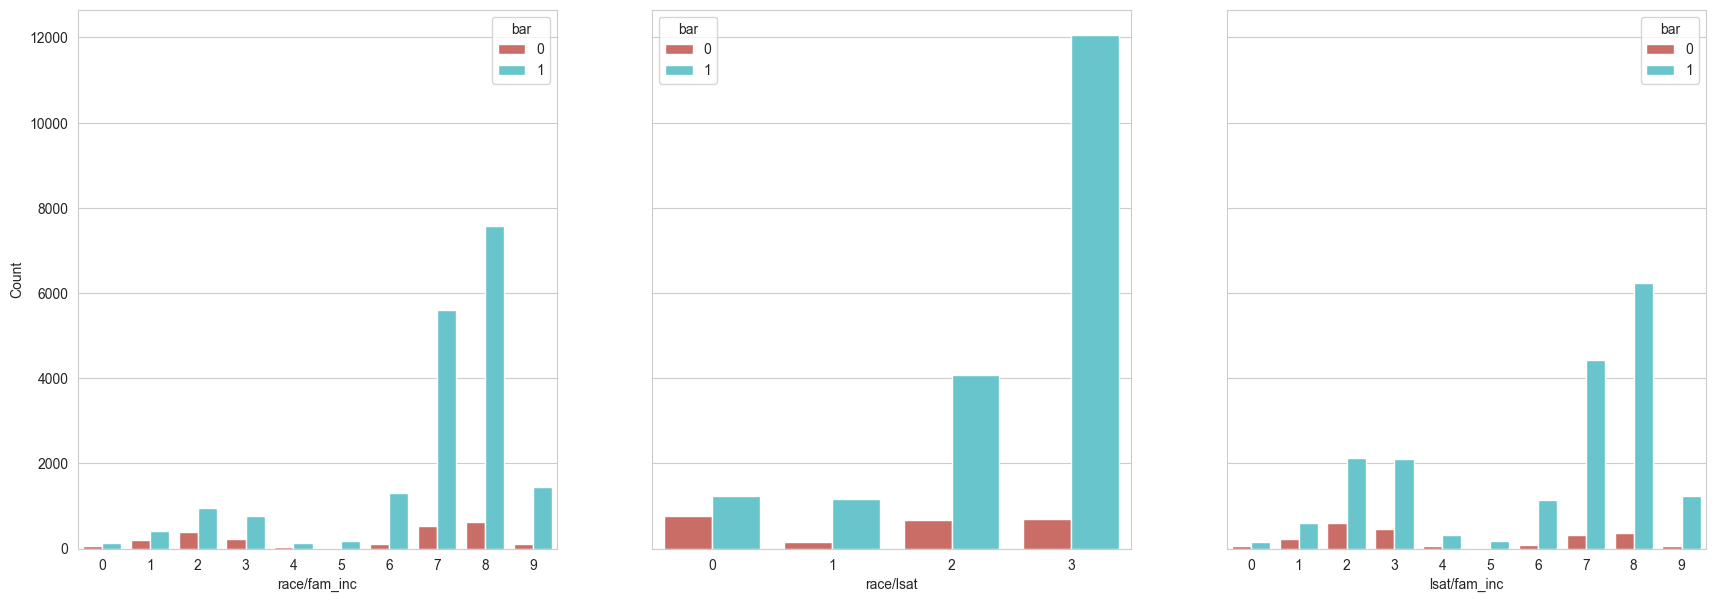

In [71]:
plot_attributes(df_num_int, protected_attributes_int)

In [53]:
df_num_int.head()

age  decile1  decile3  gender  cluster  fulltime  bar  ugpagt3  \
0    1       10       10       0        0         0    1     True   
1    1        5        4       0        1         0    1     True   
2    1        8        7       1        0         0    1     True   
3    1        8        7       0        0         0    1     True   
4    0        3        2       0        3         0    1     True   

   race/fam_inc  race/lsat  lsat/fam_inc  
0             9          1             4  
1             8          1             3  
2             7          1             2  
3             8          1             3  
4             8          1             3

In [33]:
def split_and_train(data, attributes):
    y = data.loc[:, target]
    x = data.drop(target, axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)
    models = {"Catboost",
                  "LogisticRegression",
                  "RandomForest",
                  "DecisionTree"
                  }
    y_predicted_dict = {}
    metrics_dict = {}
    for m in models:
            model = choose_model(m, x_train, y_train)
            y_predicted =  evaluate_model(model, x_train, x_test, y_train, y_test)
            attribute_metrics  = calc_metrics(x_test=x_test,y_test=y_test,y_predicted=y_predicted,attributes=attributes, target=target)
            metrics_dict[m] = attribute_metrics
            y_predicted_dict[m] = y_predicted
            print(f"Classification report for model: {model} : \n {classification_report(y_test, y_predicted)}")
            # plot_roc_curve(y_true=y_test, y_pred=y_predicted, model_name=m)
    return x_test, y_test, y_predicted_dict, metrics_dict

def plot_audit(dataset, attributes):
    audit = Audit(dataset[['score','label_value']+attributes])
    summary = audit.summary_plot(["tpr","fpr","fnr","tnr","pprev"])
    summary.show()

---------- Model name:  DecisionTree ----------

Fitting 5 folds for each of 36 candidates, totalling 180 fits
DecisionTreeClassifier(max_depth=14, min_samples_leaf=40)
Accuracy score training:
0.9019
Accuracy score test:
0.8942
----------------------------------------

Privileged groups:  [{'race': 1}]
Unprivileged groups:  [{'race': 0}]
Disparate Impact Ratio for race: 0.776
Normalized Disparate Impact Ratio for race: 0.776
Statistical Parity Difference for race: -0.221


Privileged groups:  [{'fam_inc': 4}]
Unprivileged groups:  [{'fam_inc': 1}, {'fam_inc': 5}, {'fam_inc': 2}, {'fam_inc': 3}]
Disparate Impact Ratio for fam_inc: 0.962
Normalized Disparate Impact Ratio for fam_inc: 0.962
Statistical Parity Difference for fam_inc: -0.037


Privileged groups:  [{'lsat': 2}]
Unprivileged groups:  [{'lsat': 0}, {'lsat': 1}]
Disparate Impact Ratio for lsat: 0.929
Normalized Disparate Impact Ratio for lsat: 0.929
Statistical Parity Difference for lsat: -0.069


Classification report for mod

attribute_name attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0           race               0      0.76  0.86  0.50  0.44  0.17  0.50   
1           race               1      0.92  0.99  0.11  0.43  0.08  0.89   
2        fam_inc               1      0.78  0.89  0.43  0.47  0.16  0.57   
3        fam_inc               2      0.88  0.95  0.29  0.57  0.09  0.71   
4        fam_inc               3      0.88  0.97  0.31  0.37  0.10  0.69   
5        fam_inc               4      0.91  0.99  0.18  0.43  0.08  0.82   
6        fam_inc               5      0.91  0.98  0.10  0.67  0.08  0.90   
7           lsat               0      0.73  0.80  0.60  0.37  0.22  0.40   
8           lsat               1      0.97  1.00  0.00   NaN  0.03  1.00   
9           lsat               2      0.89  0.98  0.11  0.56  0.10  0.89   

    fnr   npv  precision   ppr  pprev  prev  
0  0.14  0.56       0.83  0.12   0.76  0.73  
1  0.01  0.57       0.92  0.88   0.98  0.92  
2  0.11  0.53       0.84  0.02   0.82  0.77  
3  0.05  0.43       0.91  0.09   0.92  0.89  
4  0.03  0.63       0.90  0.36   0.93  0.87  
5  0.01  0.57       0.92  0.45   0.97  0.91  
6  0.02  0.33       0.92  0.08   0.97  0.91  
7  0.20  0.63       0.78  0.07   0.66  0.64  
8  0.00   NaN       0.97  0.27   1.00  0.97  
9  0.02  0.44       0.90  0.67   0.97  0.89

Majority class for:  race  is: 1
Majority class for:  fam_inc  is: 4
Majority class for:  lsat  is: 2
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  for_disparity  \
0           race               0           2.29          18.96           1.02   
1           race               1           1.00           1.00           1.00   
2        fam_inc               1           2.00           8.00           1.10   
3        fam_inc               2           1.11           3.49           1.33   
4        fam_inc               3           1.25           2.04           0.88   
5        fam_inc               4           1.00           1.00           1.00   
6        fam_inc               5           0.99           1.39           1.57   
7           lsat               0           2.24          11.99           0.66   
8           lsat               1           0.32           0.00            NaN   
9           lsat               2           1.00           1.00           1.00   

   fpr_disparity  npv_disparity  ppr_disparity  pprev_disparity  \
0           0.56           0.98           0.14             0.78   
1           1.00           1.00           1.00             1.00   
2           0.70           0.92           0.04             0.84   
3           0.87           0.75           0.21             0.95   
4           0.84           1.09           0.79             0.96   
5           1.00           1.00           1.00             1.00   
6           1.10           0.58           0.19             1.00   
7           0.45           1.44           0.10             0.67   
8           1.12            NaN           0.40             1.03   
9           1.00           1.00           1.00             1.00   

   precision_disparity  ...  fdr_significance  fnr_significance  \
0                 0.89  ...              True              True   
1                 1.00  ...              True              None   
2                 0.91  ...              True              None   
3                 0.99  ...             False             False   
4                 0.98  ...             False             False   
5                 1.00  ...             False             False   
6                 1.00  ...             False             False   
7                 0.86  ...              True              True   
8                 1.07  ...              True              None   
9                 1.00  ...             False             False   

   for_significance  fpr_significance  npv_significance ppr_significance  \
0              True              True              True             True   
1              None              True              None             True   
2              None              True              None             True   
3             False             False             False            False   
4             False             False             False             True   
5             False             False             False            False   
6             False             False             False            False   
7              True              True              True             True   
8              None              True              None             True   
9             False             False             False            False   

  pprev_significance  precision_significance tnr_significance  \
0               True                    True             True   
1               True                    True             True   
2               True                    True             True   
3              False                   False            False   
4               True                   False            False   
5              False                   False            False   
6              False                   False            False   
7               True                    True             True   
8               True                    True             True   
9              False                   False            False   

   tpr_significance  
0              True  
1              None  
2              

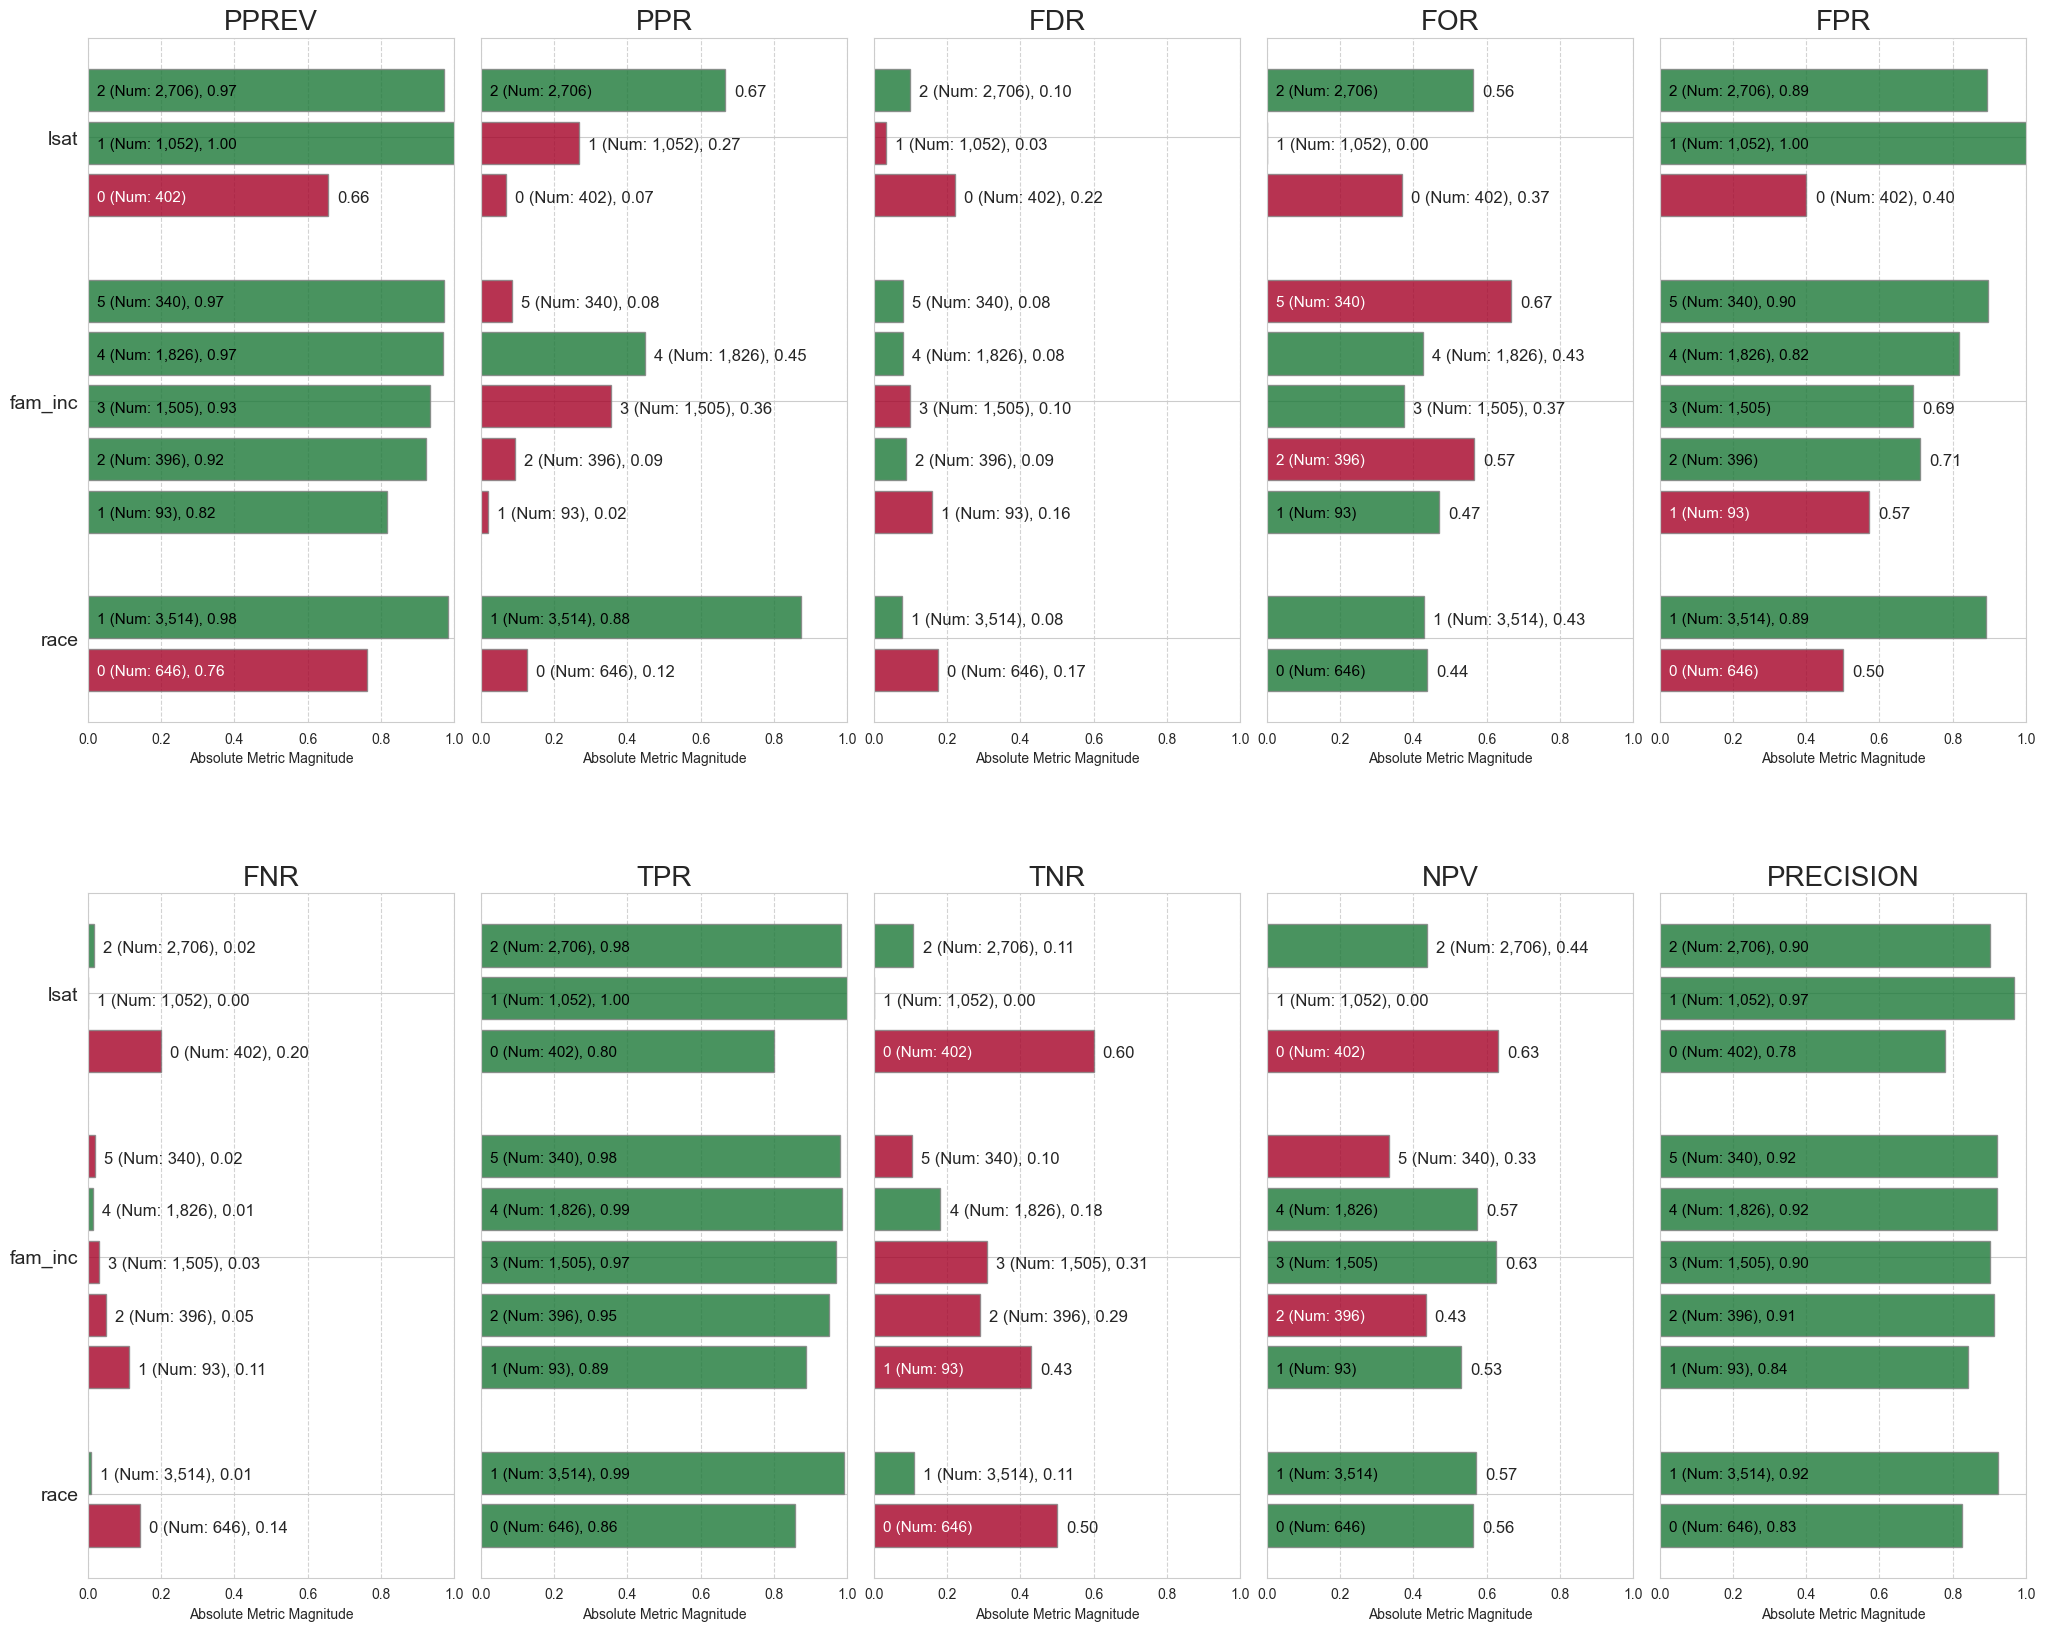

model_id score_threshold attribute_name  Statistical Parity  Impact Parity  \
0         0      binary 0/1        fam_inc               False           True   
1         0      binary 0/1           lsat               False          False   
2         0      binary 0/1           race               False          False   

   FDR Parity  FPR Parity  FOR Parity  FNR Parity  TPR Parity  TNR Parity  \
0       False       False       False       False        True       False   
1       False       False       False       False        True       False   
2       False       False        True       False        True       False   

   NPV Parity  Precision Parity  TypeI Parity  TypeII Parity  Equalized Odds  \
0       False              True         False          False           False   
1       False              True         False          False           False   
2        True              True         False          False           False   

   Unsupervised Fairness  Supervised Fairness  
0                  False                False  
1                  False                False  
2                  False                False

<Figure size 640x480 with 0 Axes>

In [34]:
"""
Train and calculate fairness metrics for original dataset.
"""
x_test, y_test, y_predicted_dict, metrics_dict = split_and_train(df_num,protected_attributes)
df_test = calc_fairness_report(x_test, y_test, y_predicted_dict['DecisionTree'], target, protected_attributes, display_disp=True)


---------- Model name:  DecisionTree ----------

Fitting 5 folds for each of 36 candidates, totalling 180 fits
DecisionTreeClassifier(max_depth=14, min_samples_leaf=60)
Accuracy score training:
0.9002
Accuracy score test:
0.8974
----------------------------------------

Privileged groups:  [{'race/fam_inc': 8}]
Unprivileged groups:  [{'race/fam_inc': 4}, {'race/fam_inc': 0}, {'race/fam_inc': 5}, {'race/fam_inc': 1}, {'race/fam_inc': 3}, {'race/fam_inc': 6}, {'race/fam_inc': 2}, {'race/fam_inc': 9}, {'race/fam_inc': 7}]
Disparate Impact Ratio for race/fam_inc: 0.943
Normalized Disparate Impact Ratio for race/fam_inc: 0.943
Statistical Parity Difference for race/fam_inc: -0.057


Privileged groups:  [{'race/lsat': 5}]
Unprivileged groups:  [{'race/lsat': 1}, {'race/lsat': 3}, {'race/lsat': 0}, {'race/lsat': 2}, {'race/lsat': 4}]
Disparate Impact Ratio for race/lsat: 0.900
Normalized Disparate Impact Ratio for race/lsat: 0.900
Statistical Parity Difference for race/lsat: -0.099


Privileg

attribute_name attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0    race/fam_inc               0      0.70  0.81  0.43  0.50  0.24  0.57   
1    race/fam_inc               1      0.76  0.81  0.59  0.56  0.12  0.41   
2    race/fam_inc               2      0.76  0.84  0.56  0.39  0.19  0.44   
3    race/fam_inc               3      0.84  0.97  0.45  0.17  0.16  0.55   
4    race/fam_inc               4      0.78  0.82  0.60  0.57  0.10  0.40   
5    race/fam_inc               5      0.85  0.98  0.14  0.50  0.13  0.86   
6    race/fam_inc               6      0.95  1.00  0.22  0.00  0.05  0.78   
7    race/fam_inc               7      0.91  0.99  0.13  0.27  0.08  0.87   
8    race/fam_inc               8      0.93  1.00  0.12  0.21  0.07  0.88   
9    race/fam_inc               9      0.93  1.00  0.08  0.33  0.07  0.92   
10      race/lsat               0      0.69  0.60  0.80  0.38  0.22  0.20   
11      race/lsat               1      0.94  1.00  0.17  0.00  0.06  0.83   
12      race/lsat               2      0.80  0.95  0.16  0.56  0.18  0.84   
13      race/lsat               3      0.81  0.96  0.39  0.25  0.18  0.61   
14      race/lsat               4      0.97  1.00  0.00   NaN  0.03  1.00   
15      race/lsat               5      0.91  1.00  0.09  0.23  0.09  0.91   
16   lsat/fam_inc               0      0.74  0.68  0.88  0.46  0.07  0.12   
17   lsat/fam_inc               1      0.69  0.67  0.73  0.47  0.18  0.27   
18   lsat/fam_inc              10      0.75  0.98  0.00  1.00  0.23  1.00   
19   lsat/fam_inc              11      0.91  0.97  0.18  0.60  0.07  0.82   
20   lsat/fam_inc              12      0.89  0.99  0.11  0.43  0.11  0.89   
21   lsat/fam_inc              13      0.91  1.00  0.12  0.12  0.09  0.88   
22   lsat/fam_inc              14      0.90  0.99  0.00  1.00  0.09  1.00   
23   lsat/fam_inc               2      0.72  0.73  0.69  0.34  0.24  0.31   
24   lsat/fam_inc               3      0.80  0.93  0.54  0.22  0.19  0.46   
25   lsat/fam_inc               4      0.78  0.78  0.80  0.50  0.07  0.20   
26   lsat/fam_inc               5      0.92  1.00  0.00   NaN  0.08  1.00   
27   lsat/fam_inc               6      0.99  1.00  0.00   NaN  0.01  1.00   
28   lsat/fam_inc               7      0.97  1.00  0.00   NaN  0.03  1.00   
29   lsat/fam_inc               8      0.97  1.00  0.00   NaN  0.03  1.00   
30   lsat/fam_inc               9      0.96  1.00  0.17  0.00  0.04  0.83   

     fnr   npv  precision   ppr  pprev  prev  
0   0.19  0.50       0.76  0.01   0.74  0.70  
1   0.19  0.44       0.88  0.02   0.72  0.79  
2   0.16  0.61       0.81  0.05   0.72  0.69  
3   0.03  0.83       0.84  0.04   0.86  0.75  
4   0.18  0.43       0.90  0.01   0.74  0.81  
5   0.02  0.50       0.87  0.01   0.96  0.85  
6   0.00  1.00       0.95  0.07   0.98  0.93  
7   0.01  0.73       0.92  0.31   0.98  0.90  
8   0.00  0.79       0.93  0.41   0.99  0.92  
9   0.00  0.67       0.93  0.08   0.99  0.92  
10  0.40  0.62       0.78  0.02   0.42  0.55  
11  0.00  1.00       0.94  0.02   0.99  0.93  
12  0.05  0.44       0.82  0.08   0.93  0.80  
13  0.04  0.75       0.82  0.04   0.87  0.75  
14  0.00   NaN       0.97  0.24   1.00  0.97  
15  0.00  0.77       0.91  0.59   0.99  0.91  
16  0.32  0.54       0.93  0.00   0.52  0.70  
17  0.33  0.53       0.82  0.01   0.53  0.66  
18  0.02  0.00       0.77  0.01   0.98  0.77  
19  0.03  0.40       0.93  0.06   0.96  0.91  
20  0.01  0.57       0.89  0.25   0.98  0.88  
21  0.00  0.88       0.91  0.30   0.99  0.90  
22  0.01  0.00       0.91  0.05   0.99  0.91  
23  0.27  0.66       0.76  0.02   0.55  0.57  
24  0.07  0.78       0.81  0.02   0.78  0.68  
25  0.22  0.50       0.93  0.00   0.65  0.78  
26  0.00   NaN       0.92  0.00   1.00  0.92  
27  0.00   NaN       0.99  0.02   1.00  0.99  
28  0.00   NaN       0.97  0.08   1.00  0.97  
29  0.00   NaN       0.97  0.13   1.00  0.97  
30  0.00  1.00       0.96  0.03   0.99  0.95

Majority class for:  race/fam_inc  is: 8
Majority class for:  race/lsat  is: 5
Majority class for:  lsat/fam_inc  is: 13
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  \
0    race/fam_inc               0           3.43          71.39   
1    race/fam_inc               1           1.70          73.93   
2    race/fam_inc               2           2.73          59.69   
3    race/fam_inc               3           2.30          11.54   
4    race/fam_inc               4           1.46          69.23   
5    race/fam_inc               5           1.94           9.52   
6    race/fam_inc               6           0.78           0.00   
7    race/fam_inc               7           1.23           2.04   
8    race/fam_inc               8           1.00           1.00   
9    race/fam_inc               9           1.03           1.32   
10      race/lsat               0           2.52         144.57   
11      race/lsat               1           0.70           0.00   
12      race/lsat               2           2.04          18.17   
13      race/lsat               3           2.05          15.75   
14      race/lsat               4           0.32           0.00   
15      race/lsat               5           1.00           1.00   
16   lsat/fam_inc               0           0.80         168.95   
17   lsat/fam_inc               1           1.99         178.33   
18   lsat/fam_inc              10           2.60          13.05   
19   lsat/fam_inc              11           0.83          13.90   
20   lsat/fam_inc              12           1.20           5.97   
21   lsat/fam_inc              13           1.00           1.00   
22   lsat/fam_inc              14           1.03           2.99   
23   lsat/fam_inc               2           2.72         142.29   
24   lsat/fam_inc               3           2.11          38.21   
25   lsat/fam_inc               4           0.75         118.89   
26   lsat/fam_inc               5           0.87           0.00   
27   lsat/fam_inc               6           0.14           0.00   
28   lsat/fam_inc               7           0.38           0.00   
29   lsat/fam_inc               8           0.31           0.00   
30   lsat/fam_inc               9           0.47           0.00   

    for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            2.38           0.65           0.63           0.02   
1            2.64           0.46           0.56           0.06   
2            1.84           0.50           0.78           0.12   
3            0.79           0.62           1.06           0.09   
4            2.71           0.45           0.54           0.01   
5            2.38           0.97           0.63           0.03   
6            0.00           0.88           1.27           0.16   
7            1.30           0.98           0.92           0.75   
8            1.00           1.00           1.00           1.00   
9            1.58           1.04           0.84           0.19   
10           1.66           0.22           0.80           0.04   
11           0.00           0.92           1.30           0.04   
12           2.43           0.92           0.57           0.14   
13           1.08           0.67           0.98           0.07   
14            NaN           1.10            NaN           0.41   
15           1.00           1.00           1.00           1.00   
16           3.69           0.14           0.62           0.01   
17           3.73           0.31           0.61           0.03   
18           8.00           1.13           0.00           0.04   
19           4.80           0.93           0.46           0.21   
20           3.48           1.01           0.65           0.85   
21           1.00           1.00           1.00           1.00   
22           8.00           1.13           0.00           0.17   
23           2.70           0.35           0.76           0.08   
24           1.78           0.52           0.89           0.08   
25           4.00           0.23           0.57           0.01   
26            NaN           1.13            NaN           0.01   
27        

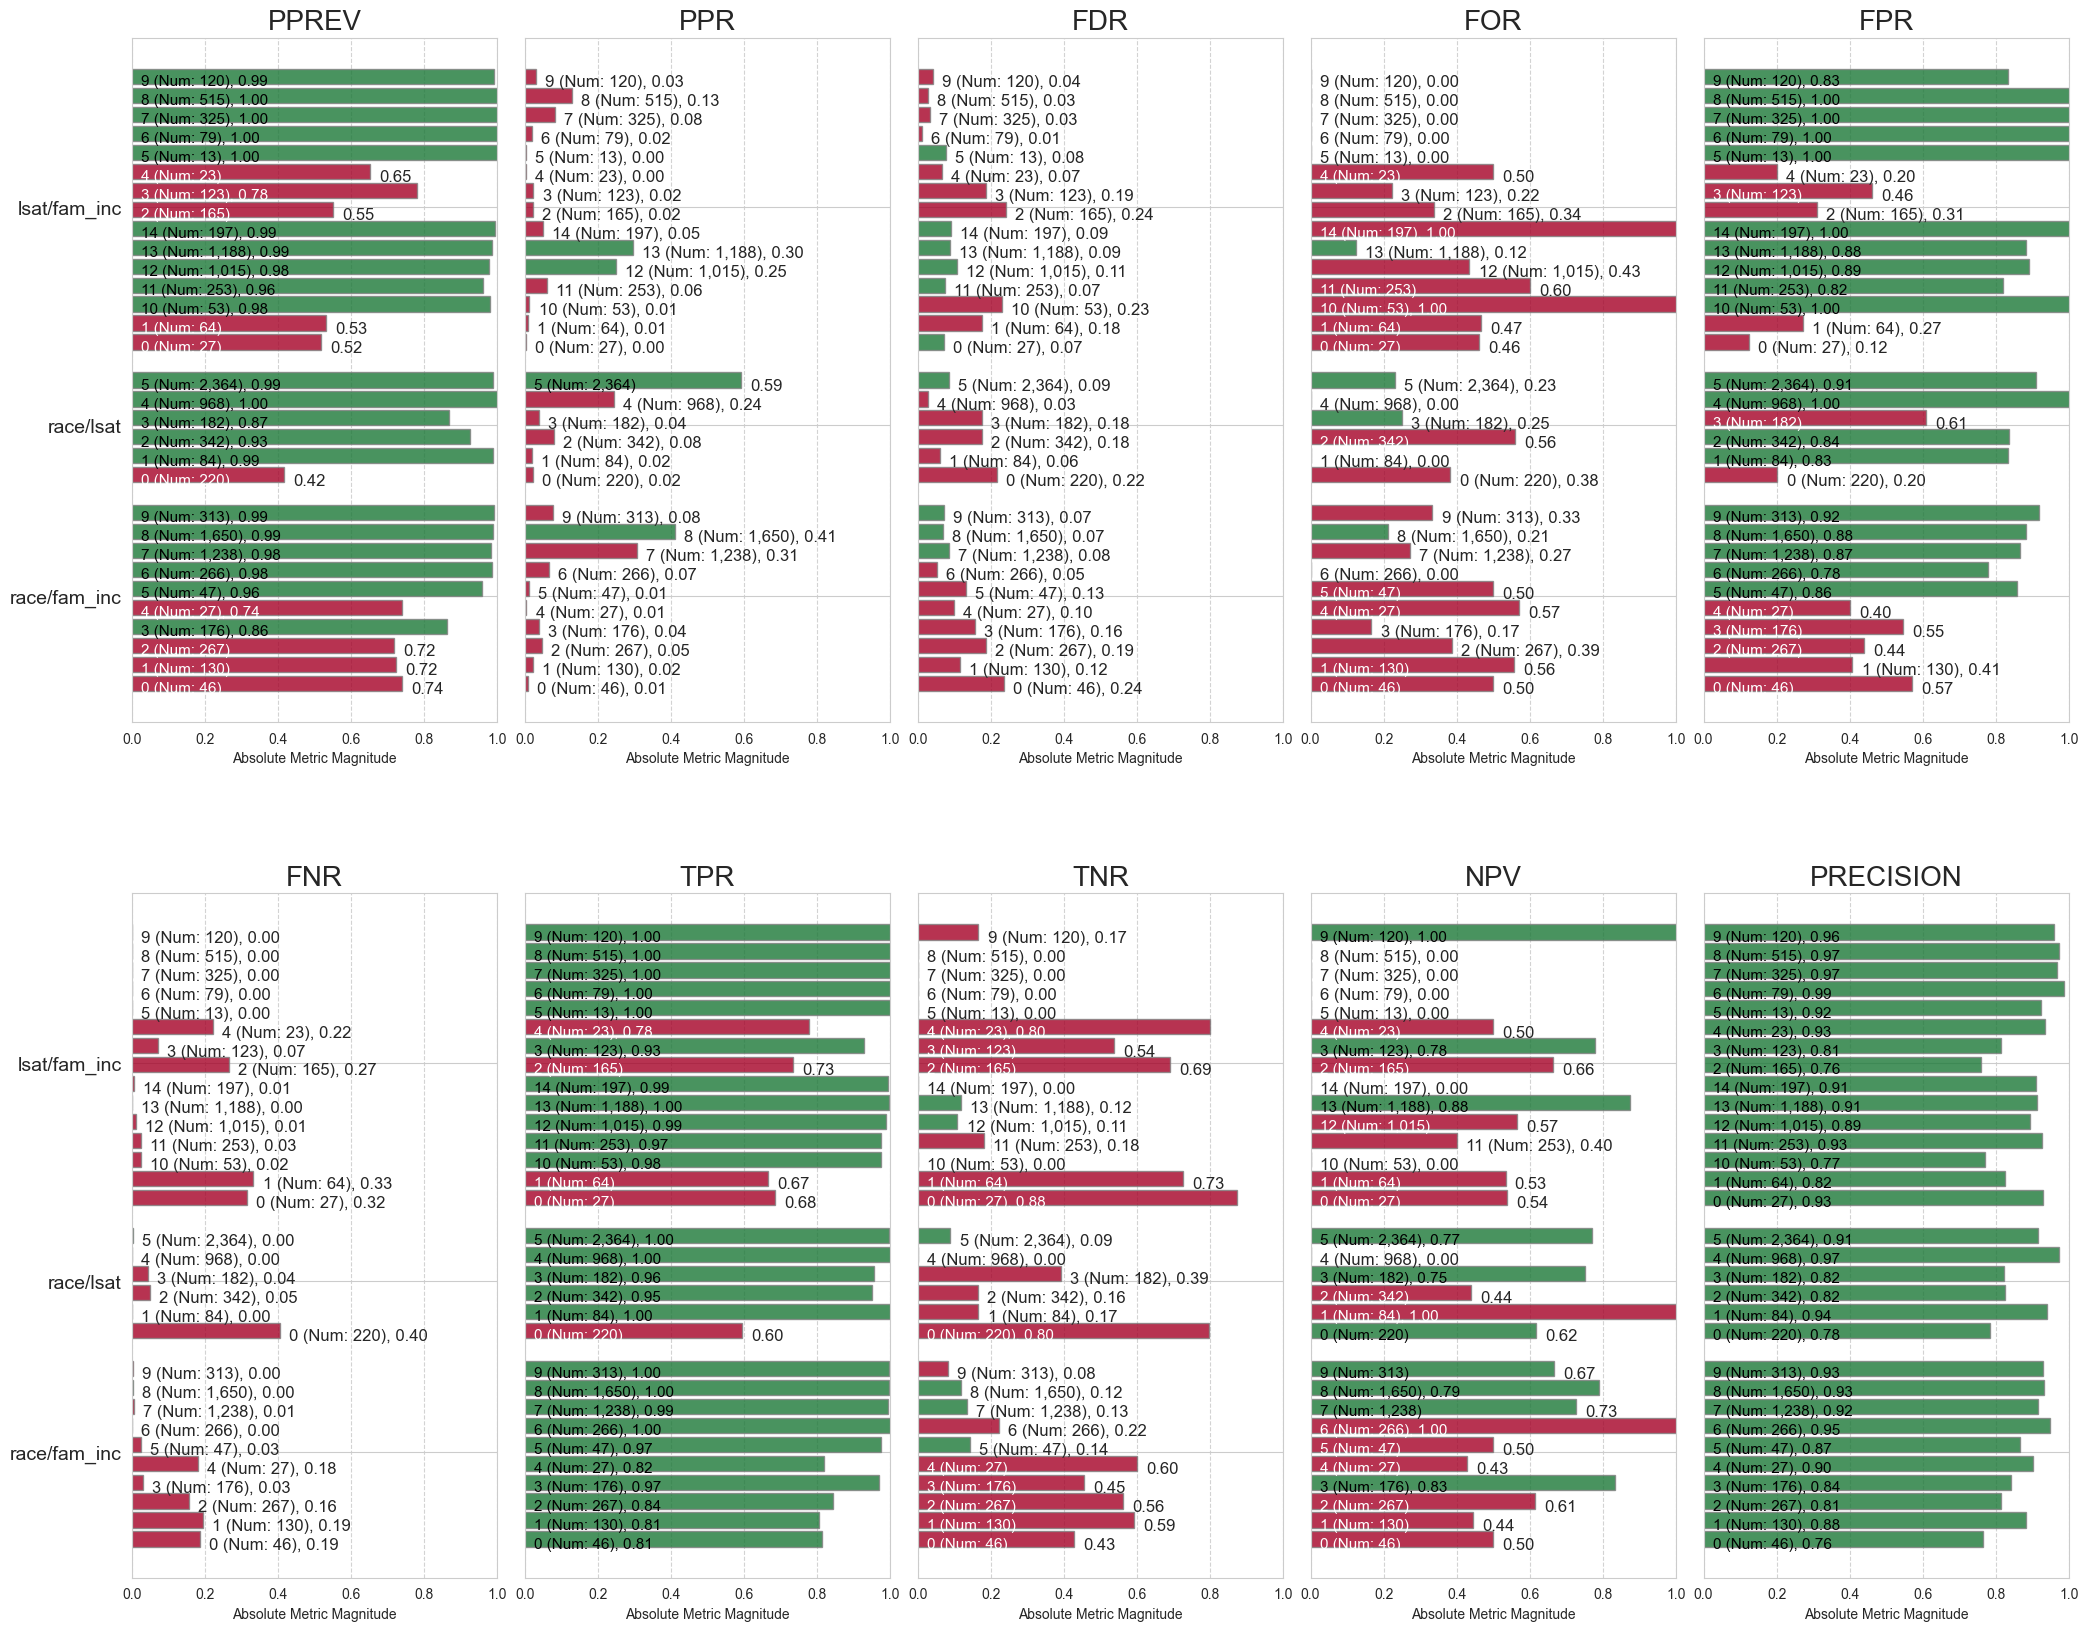

model_id score_threshold attribute_name  Statistical Parity  Impact Parity  \
0         0      binary 0/1   lsat/fam_inc               False          False   
1         0      binary 0/1   race/fam_inc               False          False   
2         0      binary 0/1      race/lsat               False          False   

   FDR Parity  FPR Parity  FOR Parity  FNR Parity  TPR Parity  TNR Parity  \
0       False       False       False       False       False       False   
1       False       False       False       False        True       False   
2       False       False       False       False       False       False   

   NPV Parity  Precision Parity  TypeI Parity  TypeII Parity  Equalized Odds  \
0       False              True         False          False           False   
1       False              True         False          False           False   
2       False              True         False          False           False   

   Unsupervised Fairness  Supervised Fairness  
0                  False                False  
1                  False                False  
2                  False                False

<Figure size 640x480 with 0 Axes>

In [23]:

"""
Train and calculate fariness metrics for the dataset obtained by the intersection of protected attributes.
"""
x_test_int, y_test_int, y_predicted_dict_int, metrics_dict_int = split_and_train(df_num_int, protected_attributes_int)
df_test_int = calc_fairness_report(x_test_int, y_test_int, y_predicted_dict_int['Catboost'], target, protected_attributes_int,display_disp=True)


---------- Model name:  DecisionTree ----------

Fitting 5 folds for each of 36 candidates, totalling 180 fits
DecisionTreeClassifier(max_depth=14, min_samples_leaf=40)
Accuracy score training:
0.9519
Accuracy score test:
0.9517
----------------------------------------

Privileged groups:  [{'race/fam_inc': 8}]
Unprivileged groups:  [{'race/fam_inc': 4}, {'race/fam_inc': 0}, {'race/fam_inc': 5}, {'race/fam_inc': 1}, {'race/fam_inc': 3}, {'race/fam_inc': 6}, {'race/fam_inc': 2}, {'race/fam_inc': 9}, {'race/fam_inc': 7}]
Disparate Impact Ratio for race/fam_inc: 0.967
Normalized Disparate Impact Ratio for race/fam_inc: 0.967
Statistical Parity Difference for race/fam_inc: -0.031


Privileged groups:  [{'race/lsat': 5}]
Unprivileged groups:  [{'race/lsat': 1}, {'race/lsat': 3}, {'race/lsat': 0}, {'race/lsat': 2}, {'race/lsat': 4}]
Disparate Impact Ratio for race/lsat: 0.990
Normalized Disparate Impact Ratio for race/lsat: 0.990
Statistical Parity Difference for race/lsat: -0.009


Privileg

attribute_name attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0    race/fam_inc               0      0.85  1.00  0.00   NaN  0.15  1.00   
1    race/fam_inc               1      0.97  0.98  0.50  0.50  0.02  0.50   
2    race/fam_inc               2      0.99  0.99  0.90  0.18  0.00  0.10   
3    race/fam_inc               3      0.99  0.99  1.00  0.33  0.00  0.00   
4    race/fam_inc               4      0.96  0.96  1.00  0.50  0.00  0.00   
5    race/fam_inc               5      0.85  1.00  0.50  0.00  0.18  0.50   
6    race/fam_inc               6      0.94  0.97  0.74  0.19  0.04  0.26   
7    race/fam_inc               7      0.95  0.99  0.78  0.05  0.05  0.22   
8    race/fam_inc               8      0.97  0.99  0.67  0.08  0.03  0.33   
9    race/fam_inc               9      0.94  0.98  0.54  0.25  0.04  0.46   
10      race/lsat               0      0.98  0.99  0.00  1.00  0.01  1.00   
11      race/lsat               1      0.99  0.99  1.00  0.33  0.00  0.00   
12      race/lsat               2      0.97  0.99  0.60  0.14  0.02  0.40   
13      race/lsat               3      0.97  0.97  0.94  0.11  0.01  0.06   
14      race/lsat               4      0.95  0.99  0.67  0.08  0.05  0.33   
15      race/lsat               5      0.96  0.99  0.71  0.08  0.04  0.29   
16   lsat/fam_inc               0      1.00  1.00  1.00  0.00  0.00  0.00   
17   lsat/fam_inc               1      0.95  1.00  0.57  0.00  0.05  0.43   
18   lsat/fam_inc              10      0.79  1.00  0.35  0.00  0.23  0.65   
19   lsat/fam_inc              11      0.95  0.98  0.73  0.15  0.04  0.27   
20   lsat/fam_inc              12      0.96  0.99  0.78  0.08  0.03  0.22   
21   lsat/fam_inc              13      0.97  1.00  0.67  0.07  0.03  0.33   
22   lsat/fam_inc              14      0.95  0.99  0.64  0.12  0.04  0.36   
23   lsat/fam_inc               2      0.98  0.99  0.94  0.12  0.01  0.06   
24   lsat/fam_inc               3      0.97  0.96  1.00  0.25  0.00  0.00   
25   lsat/fam_inc               4      0.96  0.95  1.00  0.50  0.00  0.00   
26   lsat/fam_inc               5      0.77  1.00  0.00   NaN  0.23  1.00   
27   lsat/fam_inc               6      0.95  0.95  1.00  0.67  0.00  0.00   
28   lsat/fam_inc               7      0.94  1.00  0.77  0.00  0.07  0.23   
29   lsat/fam_inc               8      0.97  1.00  0.59  0.05  0.03  0.41   
30   lsat/fam_inc               9      0.93  0.97  0.17  0.75  0.04  0.83   

     fnr   npv  precision   ppr  pprev  prev  
0   0.00   NaN       0.85  0.01   1.00  0.85  
1   0.02  0.50       0.98  0.03   0.97  0.97  
2   0.01  0.82       1.00  0.07   0.96  0.96  
3   0.01  0.67       1.00  0.05   0.98  0.99  
4   0.04  0.50       1.00  0.01   0.93  0.96  
5   0.00  1.00       0.82  0.01   0.85  0.70  
6   0.03  0.81       0.96  0.06   0.88  0.87  
7   0.01  0.95       0.95  0.28   0.85  0.82  
8   0.01  0.92       0.97  0.41   0.94  0.91  
9   0.02  0.75       0.96  0.08   0.94  0.91  
10  0.01  0.00       0.99  0.06   0.99  0.99  
11  0.01  0.67       1.00  0.02   0.96  0.98  
12  0.01  0.86       0.98  0.09   0.96  0.94  
13  0.03  0.89       0.99  0.04   0.80  0.81  
14  0.01  0.92       0.95  0.23   0.91  0.87  
15  0.01  0.92       0.96  0.57   0.91  0.88  
16  0.00  1.00       1.00  0.01   0.96  0.96  
17  0.00  1.00       0.95  0.02   0.94  0.89  
18  0.00  1.00       0.77  0.01   0.89  0.68  
19  0.02  0.85       0.96  0.06   0.90  0.88  
20  0.01  0.92       0.97  0.24   0.89  0.87  
21  0.00  0.93       0.97  0.29   0.94  0.92  
22  0.01  0.88       0.96  0.05   0.92  0.89  
23  0.01  0.88       0.99  0.04   0.90  0.90  
24  0.04  0.75       1.00  0.03   0.87  0.90  
25  0.05  0.50       1.00  0.01   0.91  0.96  
26  0.00   NaN       0.77  0.00   1.00  0.77  
27  0.05  0.33       1.00  0.02   0.92  0.97  
28  0.00  1.00       0.93  0.07   0.81  0.75  
29  0.00  0.95       0.97  0.13   0.96  0.93  
30  0.03  0.25       0.96  0.03   0.97  0.95

Majority class for:  race/fam_inc  is: 8
Majority class for:  race/lsat  is: 5
Majority class for:  lsat/fam_inc  is: 13
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  \
0    race/fam_inc               0           5.00           0.00   
1    race/fam_inc               1           0.52           2.66   
2    race/fam_inc               2           0.13           1.30   
3    race/fam_inc               3           0.00           0.96   
4    race/fam_inc               4           0.00           6.44   
5    race/fam_inc               5           5.75           0.00   
6    race/fam_inc               6           1.26           4.35   
7    race/fam_inc               7           1.49           1.48   
8    race/fam_inc               8           1.00           1.00   
9    race/fam_inc               9           1.46           2.94   
10      race/lsat               0           0.24           1.59   
11      race/lsat               1           0.00           1.41   
12      race/lsat               2           0.65           0.72   
13      race/lsat               3           0.37           3.15   
14      race/lsat               4           1.24           0.96   
15      race/lsat               5           1.00           1.00   
16   lsat/fam_inc               0           0.00           0.00   
17   lsat/fam_inc               1           1.69           0.00   
18   lsat/fam_inc              10           7.91           0.00   
19   lsat/fam_inc              11           1.19           3.90   
20   lsat/fam_inc              12           1.09           2.22   
21   lsat/fam_inc              13           1.00           1.00   
22   lsat/fam_inc              14           1.49           2.49   
23   lsat/fam_inc               2           0.23           2.92   
24   lsat/fam_inc               3           0.00           7.84   
25   lsat/fam_inc               4           0.00           9.89   
26   lsat/fam_inc               5           7.80           0.00   
27   lsat/fam_inc               6           0.00          11.30   
28   lsat/fam_inc               7           2.45           0.00   
29   lsat/fam_inc               8           0.96           0.45   
30   lsat/fam_inc               9           1.46           5.73   

    for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0             NaN           3.06            NaN           0.03   
1            5.89           1.53           0.55           0.08   
2            2.14           0.31           0.89           0.17   
3            3.93           0.00           0.73           0.11   
4            5.89           0.00           0.55           0.02   
5            0.00           1.53           1.09           0.03   
6            2.21           0.79           0.89           0.15   
7            0.58           0.67           1.04           0.68   
8            1.00           1.00           1.00           1.00   
9            2.94           1.42           0.82           0.19   
10          12.17           3.48           0.00           0.10   
11           4.06           0.00           0.73           0.04   
12           1.74           1.39           0.93           0.15   
13           1.32           0.20           0.97           0.07   
14           0.94           1.14           1.01           0.41   
15           1.00           1.00           1.00           1.00   
16           0.00           0.00           1.07           0.02   
17           0.00           1.30           1.07           0.05   
18           0.00           1.96           1.07           0.04   
19           2.22           0.81           0.91           0.20   
20           1.15           0.66           0.99           0.81   
21           1.00           1.00           1.00           1.00   
22           1.80           1.10           0.94           0.16   
23           1.69           0.19           0.95           0.13   
24           3.60           0.00           0.81           0.10   
25           7.20           0.00           0.54           0.02   
26            NaN           3.03            NaN           0.01   
27        

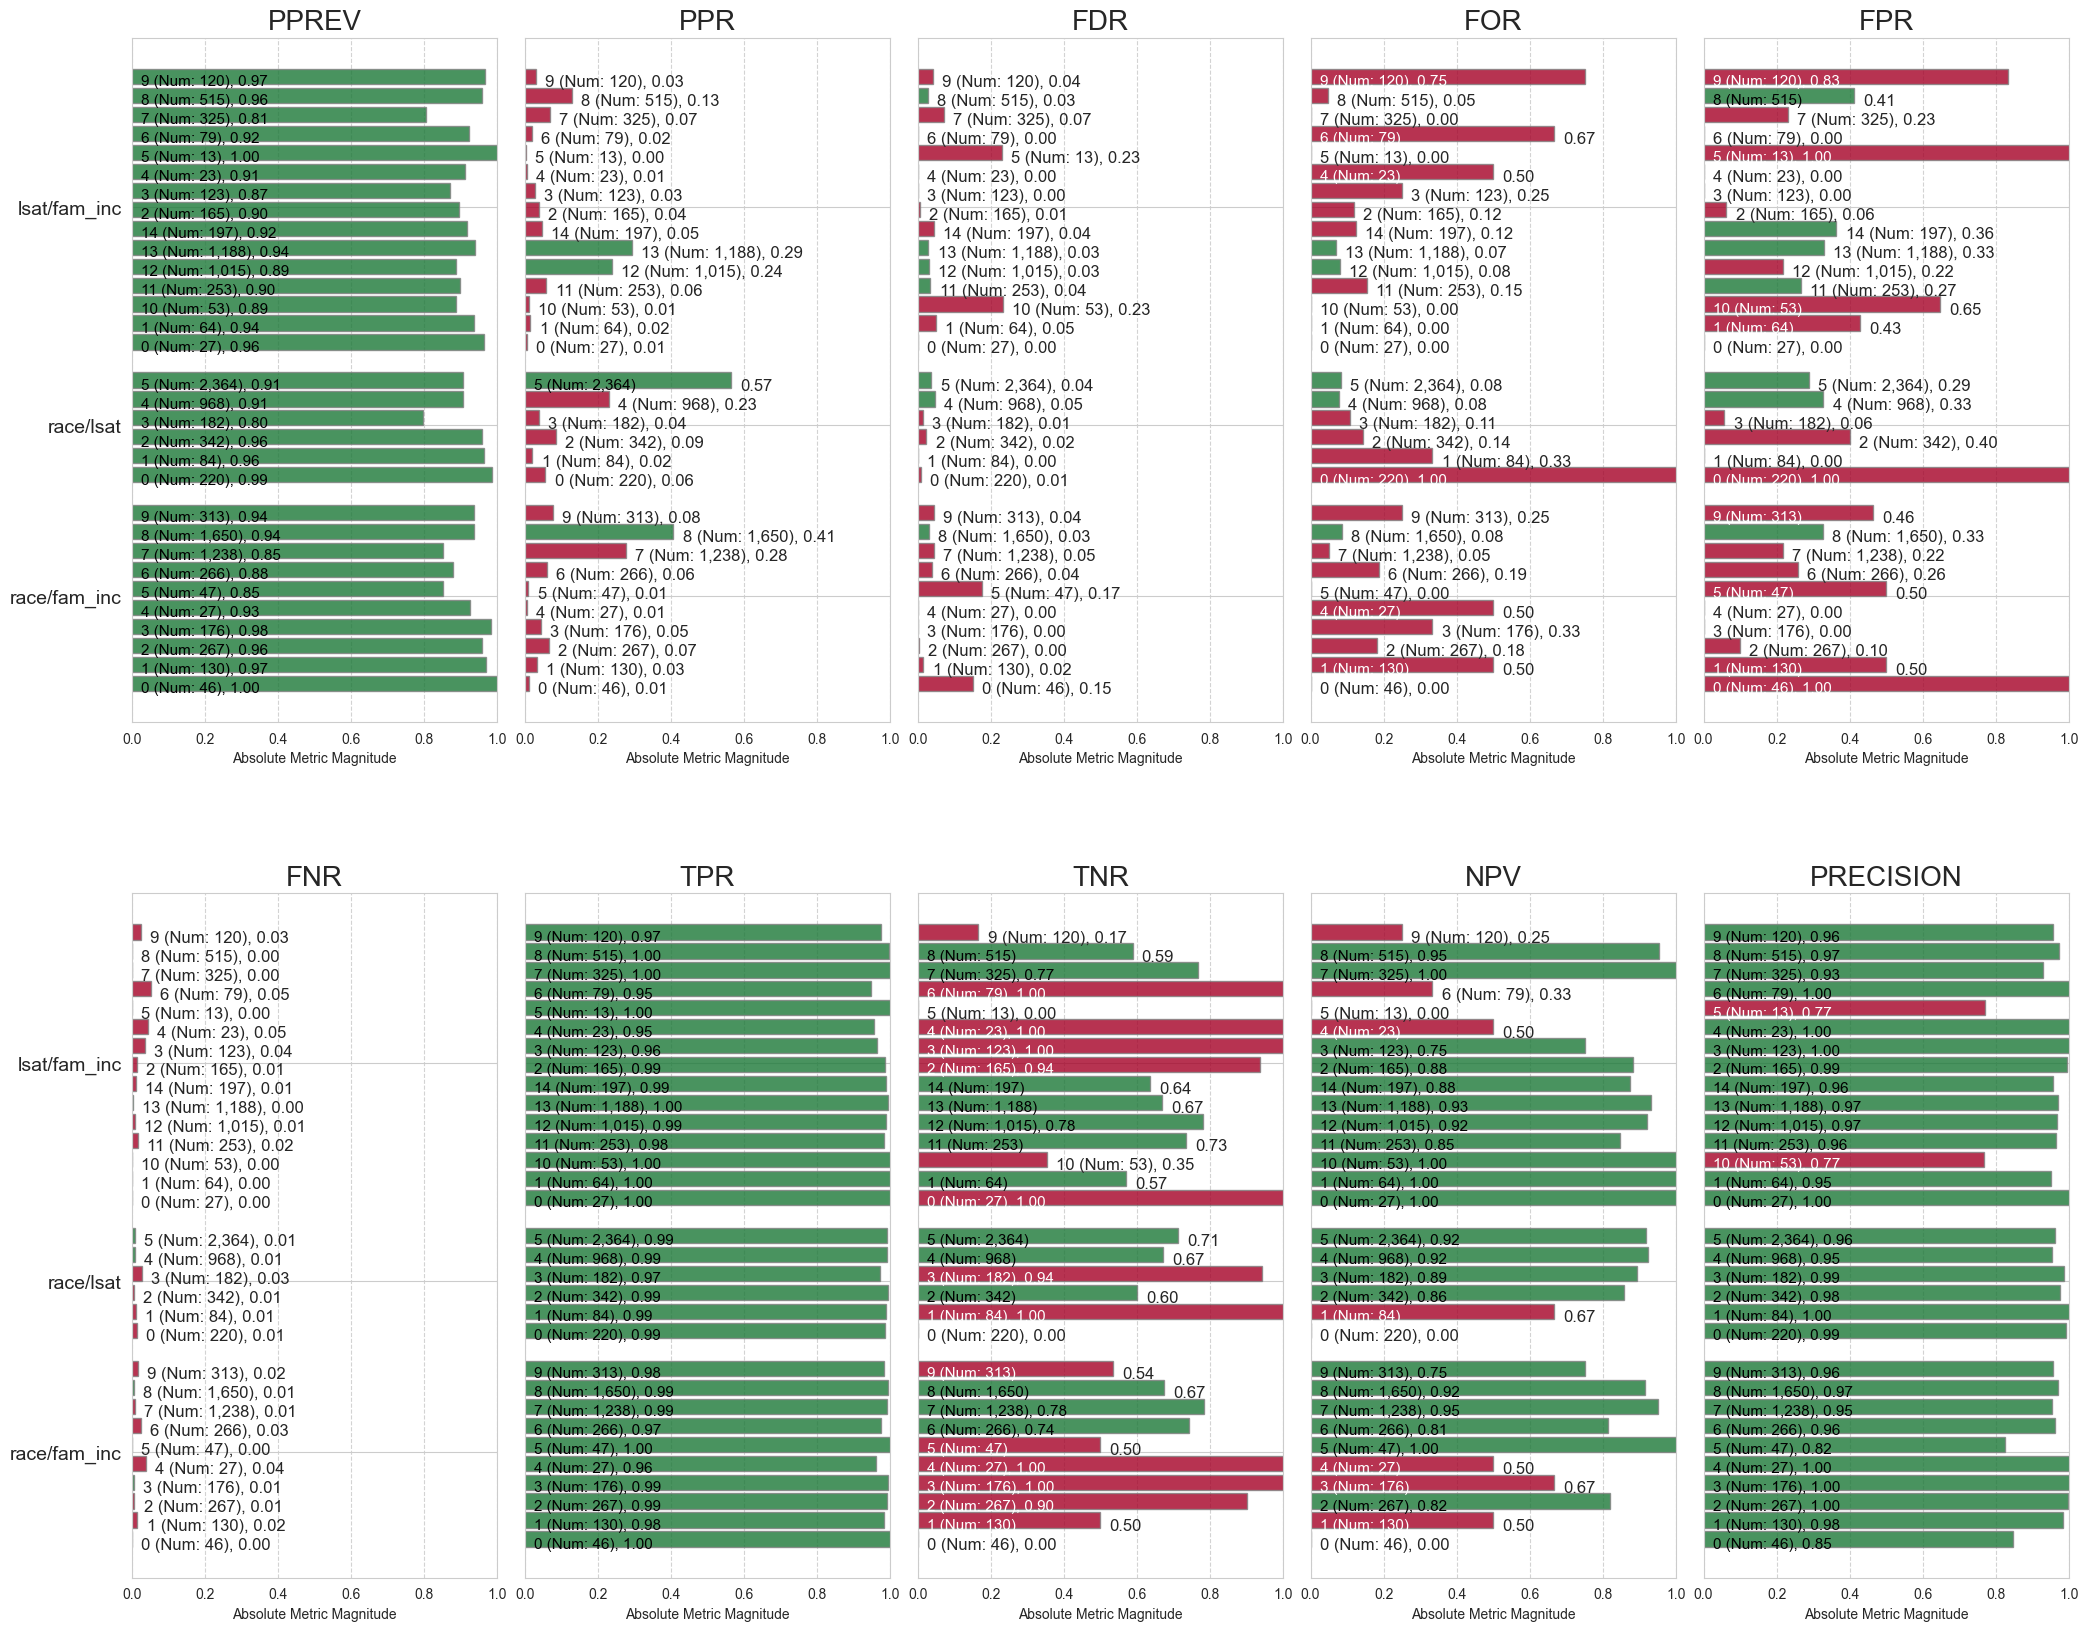

model_id score_threshold attribute_name  Statistical Parity  Impact Parity  \
0         0      binary 0/1   lsat/fam_inc               False           True   
1         0      binary 0/1   race/fam_inc               False           True   
2         0      binary 0/1      race/lsat               False           True   

   FDR Parity  FPR Parity  FOR Parity  FNR Parity  TPR Parity  TNR Parity  \
0       False       False       False       False        True       False   
1       False       False       False       False        True       False   
2       False       False       False       False        True       False   

   NPV Parity  Precision Parity  TypeI Parity  TypeII Parity  Equalized Odds  \
0       False             False         False          False           False   
1       False              True         False          False           False   
2       False              True         False          False           False   

   Unsupervised Fairness  Supervised Fairness  
0                  False                False  
1                  False                False  
2                  False                False

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

<Figure size 640x480 with 0 Axes>

In [35]:
'''
1: Massaging method (Flips selected labels to reduce prevalence disparity between groups), train and calculate metrics.
'''
#transform data
data_to_transform = prep_massaging(df_num_int, protected_attributes_int, target)
#train on the transformed dataset
x_test_ms, y_test_ms, y_predicted_dict_transformed, metrics_ms_dict = split_and_train(data_to_transform,protected_attributes_int)
df_test_transformed =calc_fairness_report(x_test_ms, y_test_ms, y_predicted_dict_transformed["Catboost"],target,protected_attributes_int, display_disp=True)

# compare disparities to the original dataset
plot_audit(df_test, protected_attributes)
plot_audit(df_test_int, protected_attributes_int)
plot_audit(df_test_transformed, protected_attributes_int)

[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Instantiating a PrevalenceSampling preprocessing method.


INFO:methods.preprocessing.PrevalenceSampling:Instantiating a PrevalenceSampling preprocessing method.


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Fitting sampling method.


INFO:methods.preprocessing.PrevalenceSampling:Fitting sampling method.


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Sampling method fitted.


INFO:methods.preprocessing.PrevalenceSampling:Sampling method fitted.


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Transforming data.


INFO:methods.preprocessing.PrevalenceSampling:Transforming data.


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Original group 9 size: 1541


INFO:methods.preprocessing.PrevalenceSampling:Original group 9 size: 1541


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Final group 9 size: 907


INFO:methods.preprocessing.PrevalenceSampling:Final group 9 size: 907


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Original group 8 size: 8199


INFO:methods.preprocessing.PrevalenceSampling:Original group 8 size: 8199


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Final group 8 size: 5660


INFO:methods.preprocessing.PrevalenceSampling:Final group 8 size: 5660


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Original group 7 size: 6131


INFO:methods.preprocessing.PrevalenceSampling:Original group 7 size: 6131


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Final group 7 size: 4744


INFO:methods.preprocessing.PrevalenceSampling:Final group 7 size: 4744


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Original group 2 size: 1338


INFO:methods.preprocessing.PrevalenceSampling:Original group 2 size: 1338


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Final group 2 size: 1061


INFO:methods.preprocessing.PrevalenceSampling:Final group 2 size: 1061


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Original group 3 size: 980


INFO:methods.preprocessing.PrevalenceSampling:Original group 3 size: 980


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Final group 3 size: 853


INFO:methods.preprocessing.PrevalenceSampling:Final group 3 size: 853


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Original group 5 size: 209


INFO:methods.preprocessing.PrevalenceSampling:Original group 5 size: 209


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Final group 5 size: 181


INFO:methods.preprocessing.PrevalenceSampling:Final group 5 size: 181


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Original group 6 size: 1413


INFO:methods.preprocessing.PrevalenceSampling:Original group 6 size: 1413


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Final group 6 size: 998


INFO:methods.preprocessing.PrevalenceSampling:Final group 6 size: 998


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Original group 4 size: 152


INFO:methods.preprocessing.PrevalenceSampling:Original group 4 size: 152


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Final group 4 size: 137


INFO:methods.preprocessing.PrevalenceSampling:Final group 4 size: 137


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Original group 1 size: 625


INFO:methods.preprocessing.PrevalenceSampling:Original group 1 size: 625


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Final group 1 size: 477


INFO:methods.preprocessing.PrevalenceSampling:Final group 1 size: 477


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Original group 0 size: 212


INFO:methods.preprocessing.PrevalenceSampling:Original group 0 size: 212


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Final group 0 size: 160


INFO:methods.preprocessing.PrevalenceSampling:Final group 0 size: 160


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Data transformed.


INFO:methods.preprocessing.PrevalenceSampling:Data transformed.


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Instantiating a PrevalenceSampling preprocessing method.


INFO:methods.preprocessing.PrevalenceSampling:Instantiating a PrevalenceSampling preprocessing method.


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Fitting sampling method.


INFO:methods.preprocessing.PrevalenceSampling:Fitting sampling method.


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Sampling method fitted.


INFO:methods.preprocessing.PrevalenceSampling:Sampling method fitted.


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Transforming data.


INFO:methods.preprocessing.PrevalenceSampling:Transforming data.


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Original group 4 size: 3373


INFO:methods.preprocessing.PrevalenceSampling:Original group 4 size: 3373


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Final group 4 size: 1278


INFO:methods.preprocessing.PrevalenceSampling:Final group 4 size: 1278


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Original group 5 size: 8451


INFO:methods.preprocessing.PrevalenceSampling:Original group 5 size: 8451


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Final group 5 size: 8351


INFO:methods.preprocessing.PrevalenceSampling:Final group 5 size: 8351


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Original group 3 size: 666


INFO:methods.preprocessing.PrevalenceSampling:Original group 3 size: 666


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Final group 3 size: 507


INFO:methods.preprocessing.PrevalenceSampling:Final group 3 size: 507


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Original group 0 size: 710


INFO:methods.preprocessing.PrevalenceSampling:Original group 0 size: 710


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Final group 0 size: 626


INFO:methods.preprocessing.PrevalenceSampling:Final group 0 size: 626


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Original group 2 size: 1584


INFO:methods.preprocessing.PrevalenceSampling:Original group 2 size: 1584


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Final group 2 size: 1206


INFO:methods.preprocessing.PrevalenceSampling:Final group 2 size: 1206


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Original group 1 size: 394


INFO:methods.preprocessing.PrevalenceSampling:Original group 1 size: 394


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Final group 1 size: 100


INFO:methods.preprocessing.PrevalenceSampling:Final group 1 size: 100


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Data transformed.


INFO:methods.preprocessing.PrevalenceSampling:Data transformed.


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Instantiating a PrevalenceSampling preprocessing method.


INFO:methods.preprocessing.PrevalenceSampling:Instantiating a PrevalenceSampling preprocessing method.


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Fitting sampling method.


INFO:methods.preprocessing.PrevalenceSampling:Fitting sampling method.


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Sampling method fitted.


INFO:methods.preprocessing.PrevalenceSampling:Sampling method fitted.


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Transforming data.


INFO:methods.preprocessing.PrevalenceSampling:Transforming data.


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Original group 12 size: 3815


INFO:methods.preprocessing.PrevalenceSampling:Original group 12 size: 3815


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Final group 12 size: 3572


INFO:methods.preprocessing.PrevalenceSampling:Final group 12 size: 3572


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Original group 8 size: 680


INFO:methods.preprocessing.PrevalenceSampling:Original group 8 size: 680


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Final group 8 size: 571


INFO:methods.preprocessing.PrevalenceSampling:Final group 8 size: 571


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Original group 13 size: 4066


INFO:methods.preprocessing.PrevalenceSampling:Original group 13 size: 4066


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Final group 13 size: 4026


INFO:methods.preprocessing.PrevalenceSampling:Final group 13 size: 4026


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Original group 2 size: 472


INFO:methods.preprocessing.PrevalenceSampling:Original group 2 size: 472


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Final group 2 size: 470


INFO:methods.preprocessing.PrevalenceSampling:Final group 2 size: 470


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Original group 7 size: 448


INFO:methods.preprocessing.PrevalenceSampling:Original group 7 size: 448


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Final group 7 size: 436


INFO:methods.preprocessing.PrevalenceSampling:Final group 7 size: 436


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Original group 3 size: 344


INFO:methods.preprocessing.PrevalenceSampling:Original group 3 size: 344


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Final group 3 size: 290


INFO:methods.preprocessing.PrevalenceSampling:Final group 3 size: 290


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Original group 10 size: 188


INFO:methods.preprocessing.PrevalenceSampling:Original group 10 size: 188


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Final group 10 size: 154


INFO:methods.preprocessing.PrevalenceSampling:Final group 10 size: 154


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Original group 11 size: 903


INFO:methods.preprocessing.PrevalenceSampling:Original group 11 size: 903


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Final group 11 size: 843


INFO:methods.preprocessing.PrevalenceSampling:Final group 11 size: 843


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Original group 14 size: 585


INFO:methods.preprocessing.PrevalenceSampling:Original group 14 size: 585


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Final group 14 size: 583


INFO:methods.preprocessing.PrevalenceSampling:Final group 14 size: 583


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Original group 9 size: 142


INFO:methods.preprocessing.PrevalenceSampling:Original group 9 size: 142


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Final group 9 size: 127


INFO:methods.preprocessing.PrevalenceSampling:Final group 9 size: 127


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Original group 1 size: 190


INFO:methods.preprocessing.PrevalenceSampling:Original group 1 size: 190


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Final group 1 size: 172


INFO:methods.preprocessing.PrevalenceSampling:Final group 1 size: 172


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Original group 6 size: 84


INFO:methods.preprocessing.PrevalenceSampling:Original group 6 size: 84


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Final group 6 size: 83


INFO:methods.preprocessing.PrevalenceSampling:Final group 6 size: 83


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Original group 4 size: 56


INFO:methods.preprocessing.PrevalenceSampling:Original group 4 size: 56


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Final group 4 size: 49


INFO:methods.preprocessing.PrevalenceSampling:Final group 4 size: 49


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Original group 0 size: 71


INFO:methods.preprocessing.PrevalenceSampling:Original group 0 size: 71


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Final group 0 size: 71


INFO:methods.preprocessing.PrevalenceSampling:Final group 0 size: 71


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Original group 5 size: 24


INFO:methods.preprocessing.PrevalenceSampling:Original group 5 size: 24


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Final group 5 size: 21


INFO:methods.preprocessing.PrevalenceSampling:Final group 5 size: 21


[INFO] 2024-10-22 16:03:43 methods.preprocessing.PrevalenceSampling - Data transformed.


INFO:methods.preprocessing.PrevalenceSampling:Data transformed.


---------- Model name:  DecisionTree ----------

Fitting 5 folds for each of 36 candidates, totalling 180 fits
DecisionTreeClassifier(max_depth=3, min_samples_leaf=40)
Accuracy score training:
0.8885
Accuracy score test:
0.8949
----------------------------------------

Privileged groups:  [{'race/fam_inc': 8}]
Unprivileged groups:  [{'race/fam_inc': 4}, {'race/fam_inc': 0}, {'race/fam_inc': 5}, {'race/fam_inc': 1}, {'race/fam_inc': 3}, {'race/fam_inc': 9}, {'race/fam_inc': 6}, {'race/fam_inc': 2}, {'race/fam_inc': 7}]
Disparate Impact Ratio for race/fam_inc: 1.000
Normalized Disparate Impact Ratio for race/fam_inc: 1.000
Statistical Parity Difference for race/fam_inc: 0.000


Privileged groups:  [{'race/lsat': 5}]
Unprivileged groups:  [{'race/lsat': 1}, {'race/lsat': 3}, {'race/lsat': 0}, {'race/lsat': 4}, {'race/lsat': 2}]
Disparate Impact Ratio for race/lsat: 1.000
Normalized Disparate Impact Ratio for race/lsat: 1.000
Statistical Parity Difference for race/lsat: 0.000


Privileged 

attribute_name attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0    race/fam_inc               0      0.91  1.00  0.00   NaN  0.09  1.00   
1    race/fam_inc               1      0.85  1.00  0.00   NaN  0.15  1.00   
2    race/fam_inc               2      0.89  1.00  0.00   NaN  0.11  1.00   
3    race/fam_inc               3      0.89  1.00  0.00   NaN  0.11  1.00   
4    race/fam_inc               4      0.94  1.00  0.00   NaN  0.06  1.00   
5    race/fam_inc               5      0.94  1.00  0.00   NaN  0.06  1.00   
6    race/fam_inc               6      0.91  1.00  0.07  0.00  0.09  0.93   
7    race/fam_inc               7      0.90  1.00  0.03  0.33  0.09  0.97   
8    race/fam_inc               8      0.89  0.99  0.09  0.31  0.10  0.91   
9    race/fam_inc               9      0.90  1.00  0.12  0.00  0.11  0.88   
10      race/lsat               0      0.91  1.00  0.00   NaN  0.09  1.00   
11      race/lsat               1      0.85  1.00  0.00   NaN  0.15  1.00   
12      race/lsat               2      0.88  1.00  0.00   NaN  0.12  1.00   
13      race/lsat               3      0.88  1.00  0.00   NaN  0.12  1.00   
14      race/lsat               4      0.93  1.00  0.11  0.00  0.07  0.89   
15      race/lsat               5      0.90  1.00  0.07  0.29  0.10  0.93   
16   lsat/fam_inc               0      0.93  1.00  0.00   NaN  0.07  1.00   
17   lsat/fam_inc               1      0.91  1.00  0.00   NaN  0.09  1.00   
18   lsat/fam_inc              10      0.92  1.00  0.00   NaN  0.08  1.00   
19   lsat/fam_inc              11      0.89  1.00  0.00   NaN  0.11  1.00   
20   lsat/fam_inc              12      0.90  1.00  0.03  0.33  0.10  0.97   
21   lsat/fam_inc              13      0.89  0.99  0.09  0.33  0.10  0.91   
22   lsat/fam_inc              14      0.91  1.00  0.15  0.00  0.09  0.85   
23   lsat/fam_inc               2      0.91  1.00  0.00   NaN  0.09  1.00   
24   lsat/fam_inc               3      0.85  1.00  0.00   NaN  0.15  1.00   
25   lsat/fam_inc               4      0.90  1.00  0.00   NaN  0.10  1.00   
26   lsat/fam_inc               5      1.00  1.00   NaN   NaN  0.00   NaN   
27   lsat/fam_inc               6      0.95  1.00  0.50  0.00  0.06  0.50   
28   lsat/fam_inc               7      0.93  1.00  0.00   NaN  0.07  1.00   
29   lsat/fam_inc               8      0.92  1.00  0.09  0.00  0.09  0.91   
30   lsat/fam_inc               9      0.87  1.00  0.00   NaN  0.13  1.00   

     fnr   npv  precision   ppr  pprev  prev  
0   0.00   NaN       0.91  0.01   1.00  0.91  
1   0.00   NaN       0.85  0.03   1.00  0.85  
2   0.00   NaN       0.89  0.07   1.00  0.89  
3   0.00   NaN       0.89  0.05   1.00  0.89  
4   0.00   NaN       0.94  0.01   1.00  0.94  
5   0.00   NaN       0.94  0.01   1.00  0.94  
6   0.00  1.00       0.91  0.07   0.99  0.91  
7   0.00  0.67       0.91  0.32   1.00  0.90  
8   0.01  0.69       0.90  0.37   0.98  0.89  
9   0.00  1.00       0.89  0.06   0.99  0.88  
10  0.00   NaN       0.91  0.05   1.00  0.91  
11  0.00   NaN       0.85  0.01   1.00  0.85  
12  0.00   NaN       0.88  0.10   1.00  0.88  
13  0.00   NaN       0.88  0.04   1.00  0.88  
14  0.00  1.00       0.93  0.10   0.99  0.92  
15  0.00  0.71       0.90  0.70   0.99  0.89  
16  0.00   NaN       0.93  0.01   1.00  0.93  
17  0.00   NaN       0.91  0.01   1.00  0.91  
18  0.00   NaN       0.92  0.02   1.00  0.92  
19  0.00   NaN       0.89  0.07   1.00  0.89  
20  0.00  0.67       0.90  0.32   1.00  0.90  
21  0.01  0.67       0.90  0.34   0.98  0.89  
22  0.00  1.00       0.91  0.05   0.98  0.89  
23  0.00   NaN       0.91  0.04   1.00  0.91  
24  0.00   NaN       0.85  0.02   1.00  0.85  
25  0.00   NaN       0.90  0.00   1.00  0.90  
26  0.00   NaN       1.00  0.00   1.00  1.00  
27  0.00  1.00       0.94  0.01   0.95  0.89  
28  0.00   NaN       0.93  0.03   1.00  0.93  
29  0.00  1.00       0.91  0.05   0.99  0.91  
30  0.00   NaN       0.87  0.01   1.00  0.87

Majority class for:  race/fam_inc  is: 8
Majority class for:  race/lsat  is: 5
Majority class for:  lsat/fam_inc  is: 13
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  \
0    race/fam_inc               0           0.85           0.00   
1    race/fam_inc               1           1.45           0.00   
2    race/fam_inc               2           1.06           0.00   
3    race/fam_inc               3           1.09           0.00   
4    race/fam_inc               4           0.54           0.00   
5    race/fam_inc               5           0.61           0.00   
6    race/fam_inc               6           0.85           0.00   
7    race/fam_inc               7           0.92           0.29   
8    race/fam_inc               8           1.00           1.00   
9    race/fam_inc               9           1.04           0.00   
10      race/lsat               0           0.94           0.00   
11      race/lsat               1           1.51           0.00   
12      race/lsat               2           1.18           0.00   
13      race/lsat               3           1.21           0.00   
14      race/lsat               4           0.75           0.00   
15      race/lsat               5           1.00           1.00   
16   lsat/fam_inc               0           0.70           0.00   
17   lsat/fam_inc               1           0.91           0.00   
18   lsat/fam_inc              10           0.81           0.00   
19   lsat/fam_inc              11           1.09           0.00   
20   lsat/fam_inc              12           0.98           0.27   
21   lsat/fam_inc              13           1.00           1.00   
22   lsat/fam_inc              14           0.90           0.00   
23   lsat/fam_inc               2           0.87           0.00   
24   lsat/fam_inc               3           1.42           0.00   
25   lsat/fam_inc               4           0.97           0.00   
26   lsat/fam_inc               5           0.00           0.00   
27   lsat/fam_inc               6           0.54           0.00   
28   lsat/fam_inc               7           0.64           0.00   
29   lsat/fam_inc               8           0.83           0.00   
30   lsat/fam_inc               9           1.26           0.00   

    for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0             NaN           1.10            NaN           0.03   
1             NaN           1.10            NaN           0.07   
2             NaN           1.10            NaN           0.20   
3             NaN           1.10            NaN           0.13   
4             NaN           1.10            NaN           0.02   
5             NaN           1.10            NaN           0.04   
6            0.00           1.03           1.44           0.18   
7            1.08           1.07           0.96           0.87   
8            1.00           1.00           1.00           1.00   
9            0.00           0.97           1.44           0.17   
10            NaN           1.08            NaN           0.07   
11            NaN           1.08            NaN           0.01   
12            NaN           1.08            NaN           0.15   
13            NaN           1.08            NaN           0.05   
14           0.00           0.96           1.42           0.14   
15           1.00           1.00           1.00           1.00   
16            NaN           1.10            NaN           0.02   
17            NaN           1.10            NaN           0.04   
18            NaN           1.10            NaN           0.05   
19            NaN           1.10            NaN           0.21   
20           1.00           1.07           1.00           0.94   
21           1.00           1.00           1.00           1.00   
22           0.00           0.93           1.50           0.15   
23            NaN           1.10            NaN           0.12   
24            NaN           1.10            NaN           0.07   
25            NaN           1.10            NaN           0.01   
26            NaN            NaN            NaN           0.01   
27        

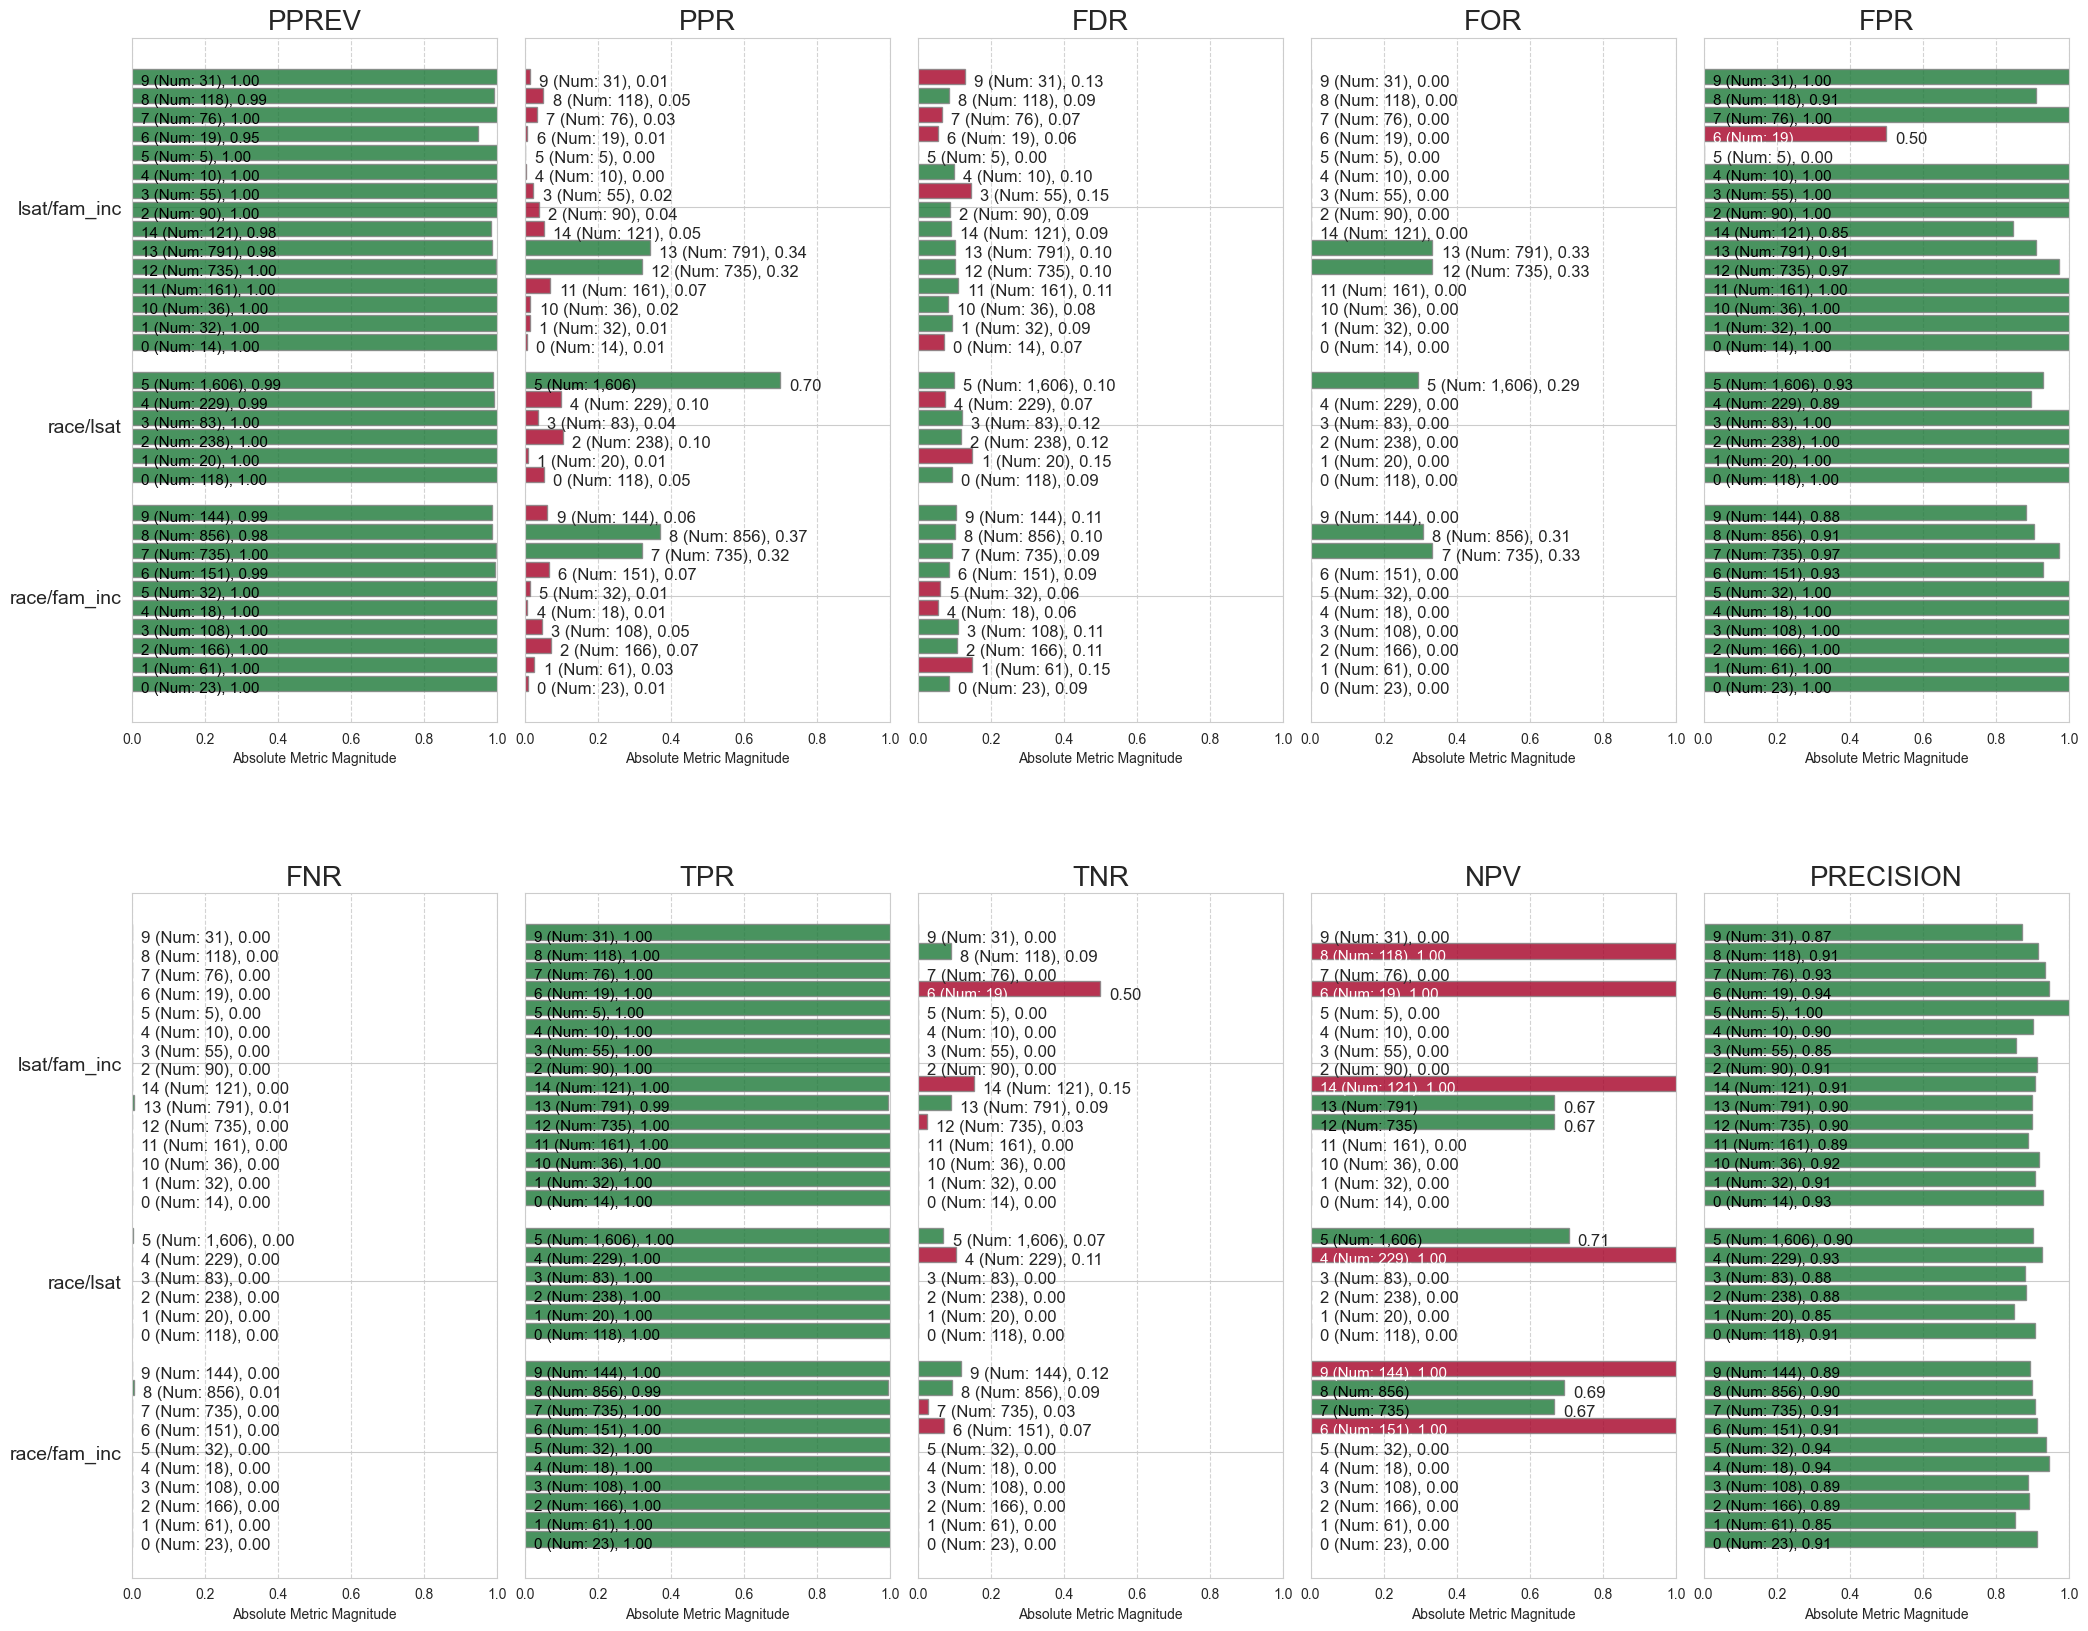

model_id score_threshold attribute_name  Statistical Parity  Impact Parity  \
0         0      binary 0/1   lsat/fam_inc               False           True   
1         0      binary 0/1   race/fam_inc               False           True   
2         0      binary 0/1      race/lsat               False           True   

   FDR Parity  FPR Parity  FOR Parity  FNR Parity  TPR Parity  TNR Parity  \
0       False       False       False       False        True       False   
1       False        True       False       False        True       False   
2       False        True       False       False        True       False   

   NPV Parity  Precision Parity  TypeI Parity  TypeII Parity  Equalized Odds  \
0       False              True         False          False           False   
1       False              True         False          False            True   
2       False              True         False          False            True   

   Unsupervised Fairness  Supervised Fairness  
0                  False                False  
1                  False                False  
2                  False                False

alt.VConcatChart(...)

alt.VConcatChart(...)

<Figure size 640x480 with 0 Axes>

In [36]:
''' 
2: Prevalance Sampling: Generates a training sample with controllable balanced prevalence for the groups in dataset, either by undersampling or oversampling.
'''
#transform data
data_to_transform = prep_prev_sampling(df_num_int, protected_attributes_int, target)
#train the new dataset
x_test_ps, y_test_ps, y_predicted_dict_ps, metrics_ps_dict = split_and_train(data_to_transform,protected_attributes_int)
df_test_transformed_ps =calc_fairness_report(x_test_ps, y_test_ps, y_predicted_dict_ps["RandomForest"],target,protected_attributes_int, display_disp=True)

#compare disparities
plot_audit(df_test_int, protected_attributes_int)
plot_audit(df_test_transformed_ps, protected_attributes_int)

---------- Model name:  DecisionTree ----------

Fitting 5 folds for each of 36 candidates, totalling 180 fits
DecisionTreeClassifier(max_depth=14, min_samples_leaf=50)
Accuracy score training:
0.9002
Accuracy score test:
0.8940
----------------------------------------

Privileged groups:  [{'race/fam_inc': 8}]
Unprivileged groups:  [{'race/fam_inc': 4}, {'race/fam_inc': 0}, {'race/fam_inc': 5}, {'race/fam_inc': 1}, {'race/fam_inc': 3}, {'race/fam_inc': 6}, {'race/fam_inc': 2}, {'race/fam_inc': 9}, {'race/fam_inc': 7}]
Disparate Impact Ratio for race/fam_inc: 0.948
Normalized Disparate Impact Ratio for race/fam_inc: 0.948
Statistical Parity Difference for race/fam_inc: -0.051


Privileged groups:  [{'race/lsat': 5}]
Unprivileged groups:  [{'race/lsat': 1}, {'race/lsat': 3}, {'race/lsat': 0}, {'race/lsat': 2}, {'race/lsat': 4}]
Disparate Impact Ratio for race/lsat: 0.908
Normalized Disparate Impact Ratio for race/lsat: 0.908
Statistical Parity Difference for race/lsat: -0.090


Privileg

attribute_name attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0    race/fam_inc               0      0.70  0.81  0.43  0.50  0.24  0.57   
1    race/fam_inc               1      0.81  0.87  0.56  0.46  0.12  0.44   
2    race/fam_inc               2      0.75  0.85  0.54  0.39  0.19  0.46   
3    race/fam_inc               3      0.80  0.96  0.32  0.26  0.19  0.68   
4    race/fam_inc               4      0.81  0.91  0.40  0.50  0.13  0.60   
5    race/fam_inc               5      0.87  1.00  0.14  0.00  0.13  0.86   
6    race/fam_inc               6      0.94  1.00  0.11  0.00  0.06  0.89   
7    race/fam_inc               7      0.91  1.00  0.07  0.20  0.09  0.93   
8    race/fam_inc               8      0.92  1.00  0.03  0.33  0.07  0.97   
9    race/fam_inc               9      0.93  1.00  0.04  0.00  0.07  0.96   
10      race/lsat               0      0.68  0.64  0.74  0.38  0.25  0.26   
11      race/lsat               1      0.93  1.00  0.00   NaN  0.07  1.00   
12      race/lsat               2      0.80  0.96  0.12  0.56  0.18  0.88   
13      race/lsat               3      0.80  0.98  0.26  0.20  0.20  0.74   
14      race/lsat               4      0.97  1.00  0.00   NaN  0.03  1.00   
15      race/lsat               5      0.91  1.00  0.02  0.20  0.09  0.98   
16   lsat/fam_inc               0      0.74  0.68  0.88  0.46  0.07  0.12   
17   lsat/fam_inc               1      0.75  0.76  0.73  0.38  0.16  0.27   
18   lsat/fam_inc              10      0.77  1.00  0.00   NaN  0.23  1.00   
19   lsat/fam_inc              11      0.91  0.99  0.05  0.75  0.08  0.95   
20   lsat/fam_inc              12      0.88  0.99  0.06  0.50  0.11  0.94   
21   lsat/fam_inc              13      0.90  1.00  0.03  0.25  0.10  0.97   
22   lsat/fam_inc              14      0.91  1.00  0.06  0.00  0.09  0.94   
23   lsat/fam_inc               2      0.70  0.76  0.63  0.34  0.27  0.37   
24   lsat/fam_inc               3      0.76  0.93  0.38  0.29  0.24  0.62   
25   lsat/fam_inc               4      0.78  0.89  0.40  0.50  0.16  0.60   
26   lsat/fam_inc               5      0.92  1.00  0.00   NaN  0.08  1.00   
27   lsat/fam_inc               6      0.99  1.00  0.00   NaN  0.01  1.00   
28   lsat/fam_inc               7      0.97  1.00  0.00   NaN  0.03  1.00   
29   lsat/fam_inc               8      0.97  1.00  0.00   NaN  0.03  1.00   
30   lsat/fam_inc               9      0.95  1.00  0.00   NaN  0.05  1.00   

     fnr   npv  precision   ppr  pprev  prev  
0   0.19  0.50       0.76  0.01   0.74  0.70  
1   0.13  0.54       0.88  0.03   0.78  0.79  
2   0.15  0.61       0.81  0.05   0.73  0.69  
3   0.04  0.74       0.81  0.04   0.89  0.75  
4   0.09  0.50       0.87  0.01   0.85  0.81  
5   0.00  1.00       0.87  0.01   0.98  0.85  
6   0.00  1.00       0.94  0.07   0.99  0.93  
7   0.00  0.80       0.91  0.31   0.99  0.90  
8   0.00  0.67       0.93  0.41   1.00  0.92  
9   0.00  1.00       0.93  0.08   1.00  0.92  
10  0.36  0.62       0.75  0.03   0.47  0.55  
11  0.00   NaN       0.93  0.02   1.00  0.93  
12  0.04  0.44       0.82  0.08   0.95  0.80  
13  0.02  0.80       0.80  0.04   0.92  0.75  
14  0.00   NaN       0.97  0.24   1.00  0.97  
15  0.00  0.80       0.91  0.59   1.00  0.91  
16  0.32  0.54       0.93  0.00   0.52  0.70  
17  0.24  0.62       0.84  0.01   0.59  0.66  
18  0.00   NaN       0.77  0.01   1.00  0.77  
19  0.01  0.25       0.92  0.06   0.98  0.91  
20  0.01  0.50       0.89  0.25   0.99  0.88  
21  0.00  0.75       0.90  0.30   1.00  0.90  
22  0.00  1.00       0.91  0.05   0.99  0.91  
23  0.24  0.66       0.73  0.02   0.59  0.57  
24  0.07  0.71       0.76  0.03   0.83  0.68  
25  0.11  0.50       0.84  0.00   0.83  0.78  
26  0.00   NaN       0.92  0.00   1.00  0.92  
27  0.00   NaN       0.99  0.02   1.00  0.99  
28  0.00   NaN       0.97  0.08   1.00  0.97  
29  0.00   NaN       0.97  0.13   1.00  0.97  
30  0.00   NaN       0.95  0.03   1.00  0.95

Majority class for:  race/fam_inc  is: 8
Majority class for:  race/lsat  is: 5
Majority class for:  lsat/fam_inc  is: 13
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  \
0    race/fam_inc               0           3.14         142.78   
1    race/fam_inc               1           1.57          96.11   
2    race/fam_inc               2           2.60         115.25   
3    race/fam_inc               3           2.55          28.84   
4    race/fam_inc               4           1.74          69.23   
5    race/fam_inc               5           1.74           0.00   
6    race/fam_inc               6           0.81           0.00   
7    race/fam_inc               7           1.21           1.36   
8    race/fam_inc               8           1.00           1.00   
9    race/fam_inc               9           0.99           0.00   
10      race/lsat               0           2.73         778.91   
11      race/lsat               1           0.77           0.00   
12      race/lsat               2           1.97          77.89   
13      race/lsat               3           2.20          47.25   
14      race/lsat               4           0.30           0.00   
15      race/lsat               5           1.00           1.00   
16   lsat/fam_inc               0           0.74         337.89   
17   lsat/fam_inc               1           1.63         254.76   
18   lsat/fam_inc              10           2.33           0.00   
19   lsat/fam_inc              11           0.87          13.90   
20   lsat/fam_inc              12           1.15           8.36   
21   lsat/fam_inc              13           1.00           1.00   
22   lsat/fam_inc              14           0.89           0.00   
23   lsat/fam_inc               2           2.76         261.81   
24   lsat/fam_inc               3           2.42          76.43   
25   lsat/fam_inc               4           1.63         118.89   
26   lsat/fam_inc               5           0.79           0.00   
27   lsat/fam_inc               6           0.13           0.00   
28   lsat/fam_inc               7           0.35           0.00   
29   lsat/fam_inc               8           0.28           0.00   
30   lsat/fam_inc               9           0.51           0.00   

    for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            1.50           0.59           0.75           0.02   
1            1.39           0.46           0.80           0.06   
2            1.17           0.48           0.92           0.12   
3            0.79           0.70           1.11           0.10   
4            1.50           0.62           0.75           0.01   
5            0.00           0.89           1.50           0.03   
6            0.00           0.92           1.50           0.16   
7            0.60           0.96           1.20           0.75   
8            1.00           1.00           1.00           1.00   
9            0.00           0.99           1.50           0.19   
10           1.88           0.27           0.78           0.04   
11            NaN           1.02            NaN           0.04   
12           2.78           0.90           0.56           0.14   
13           1.00           0.75           1.00           0.07   
14            NaN           1.02            NaN           0.41   
15           1.00           1.00           1.00           1.00   
16           1.85           0.13           0.72           0.01   
17           1.54           0.28           0.82           0.03   
18            NaN           1.03            NaN           0.04   
19           3.00           0.98           0.33           0.21   
20           2.00           0.97           0.67           0.85   
21           1.00           1.00           1.00           1.00   
22           0.00           0.97           1.33           0.17   
23           1.35           0.38           0.88           0.08   
24           1.14           0.63           0.95           0.09   
25           2.00           0.62           0.67           0.02   
26            NaN           1.03            NaN           0.01   
27        

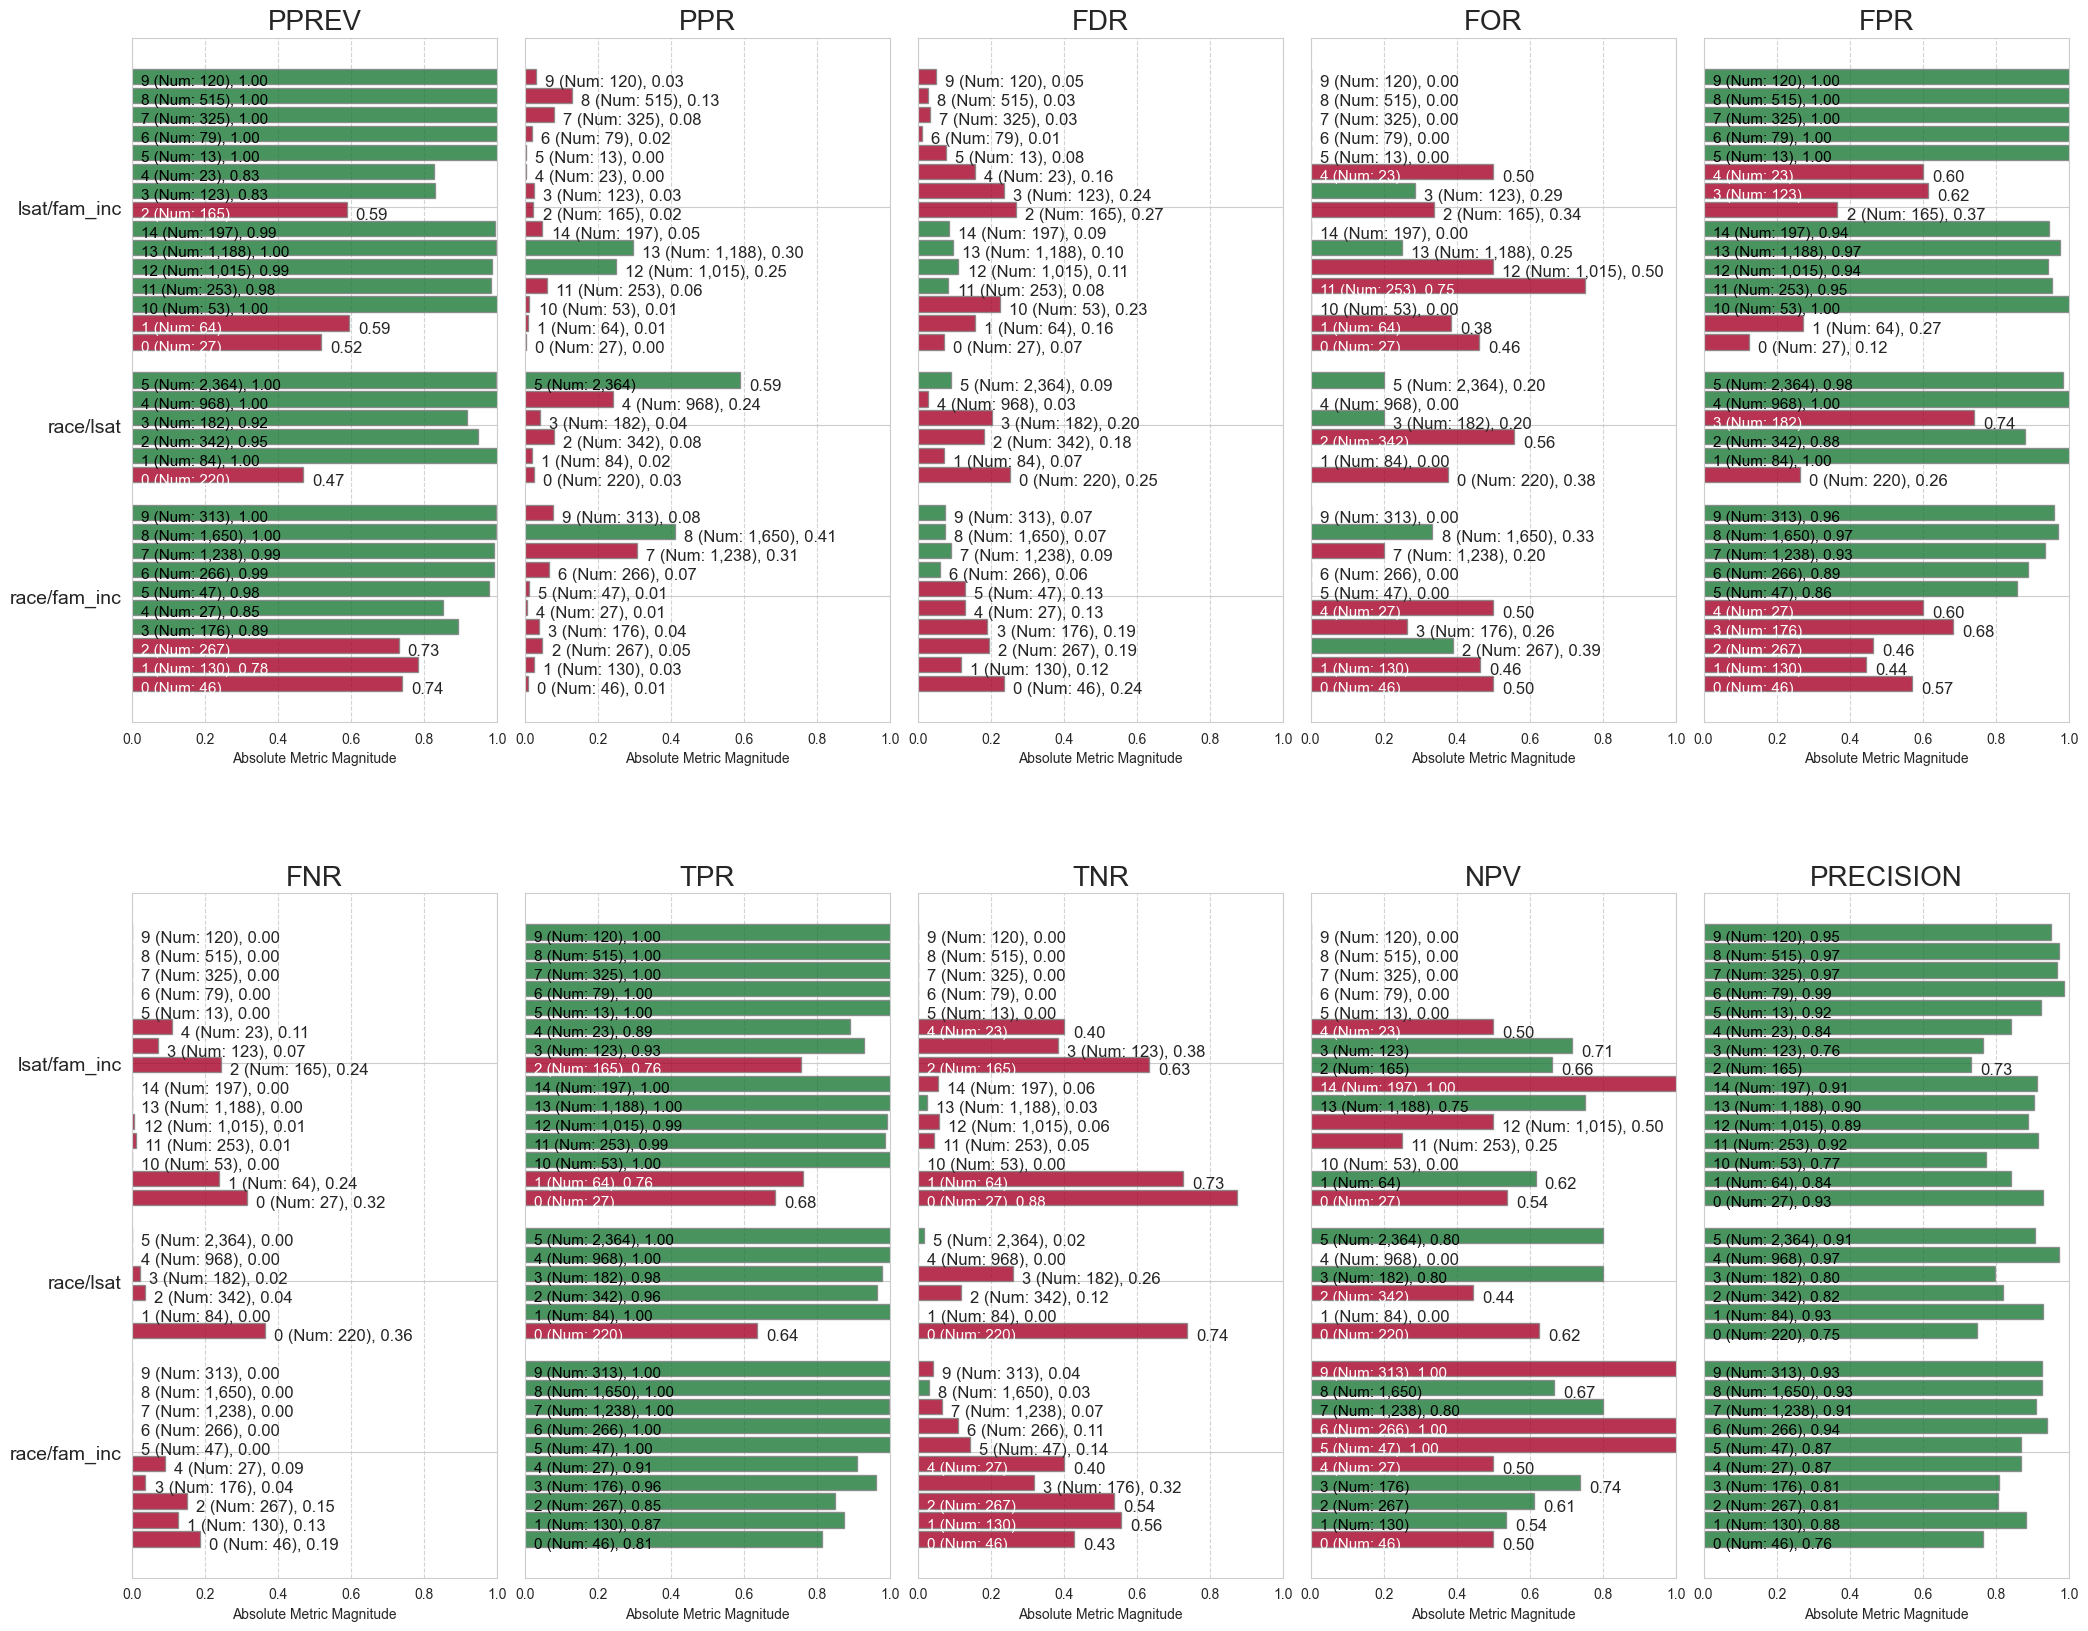

model_id score_threshold attribute_name  Statistical Parity  Impact Parity  \
0         0      binary 0/1   lsat/fam_inc               False          False   
1         0      binary 0/1   race/fam_inc               False          False   
2         0      binary 0/1      race/lsat               False          False   

   FDR Parity  FPR Parity  FOR Parity  FNR Parity  TPR Parity  TNR Parity  \
0       False       False       False       False       False       False   
1       False       False       False       False        True       False   
2       False       False       False       False       False       False   

   NPV Parity  Precision Parity  TypeI Parity  TypeII Parity  Equalized Odds  \
0       False              True         False          False           False   
1       False              True         False          False           False   
2       False              True         False          False           False   

   Unsupervised Fairness  Supervised Fairness  
0                  False                False  
1                  False                False  
2                  False                False

alt.VConcatChart(...)

alt.VConcatChart(...)

<Figure size 640x480 with 0 Axes>

In [37]:
'''
3. Data repairer: Transforms the data distribution so that a given feature distribution is marginally independent of the sensitive attribute, s. 
'''
data_to_transform = prep_data_repairer(df_num_int, protected_attributes_int, target)
#train
x_test_dr, y_test_dr, y_predicted_dict_dr, metrics_dr_dict = split_and_train(data_to_transform,protected_attributes_int)

#calc metrics
df_test_transformed_dr =calc_fairness_report(x_test_dr, y_test_dr, y_predicted_dict_dr["RandomForest"],target,protected_attributes_int,display_disp=True)

#compare disparities
plot_audit(df_test_int, protected_attributes_int)
plot_audit(df_test_transformed_dr, protected_attributes_int)

In [41]:
'''
4. Label flipping
'''

#transform data
data_to_transform = prep_label_flipping(df_num_int, protected_attributes_int, target)

#train
x_test_lf, y_test_lf, y_predicted_dict_lf, metrics_lf_dict = split_and_train(data_to_transform,
                                                                             protected_attributes_int)

#calc metrics
df_test_transformed_lf = calc_fairness_report(x_test_lf, y_test_lf, y_predicted_dict_lf["RandomForest"], target,
                                              protected_attributes_int, display_disp=True)

#compare disparities
plot_audit(df_test_int, protected_attributes_int)
plot_audit(df_test_transformed_lf, protected_attributes_int)

[INFO] 2024-10-22 16:25:13 methods.preprocessing.LabelFlipping - Instantiating a LabelFlipping preprocessing method.


INFO:methods.preprocessing.LabelFlipping:Instantiating a LabelFlipping preprocessing method.


[INFO] 2024-10-22 16:25:13 methods.preprocessing.LabelFlipping - Fitting LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Fitting LabelFlipping.


[INFO] 2024-10-22 16:25:13 methods.preprocessing.LabelFlipping - Transforming data with LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Transforming data with LabelFlipping.


[INFO] 2024-10-22 16:25:13 methods.preprocessing.LabelFlipping - Flipped 635 instances.


INFO:methods.preprocessing.LabelFlipping:Flipped 635 instances.


[INFO] 2024-10-22 16:25:13 methods.preprocessing.LabelFlipping - Data transformed.


INFO:methods.preprocessing.LabelFlipping:Data transformed.


[INFO] 2024-10-22 16:25:13 methods.preprocessing.LabelFlipping - Instantiating a LabelFlipping preprocessing method.


INFO:methods.preprocessing.LabelFlipping:Instantiating a LabelFlipping preprocessing method.


[INFO] 2024-10-22 16:25:13 methods.preprocessing.LabelFlipping - Fitting LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Fitting LabelFlipping.


[INFO] 2024-10-22 16:25:13 methods.preprocessing.LabelFlipping - Transforming data with LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Transforming data with LabelFlipping.


[INFO] 2024-10-22 16:25:13 methods.preprocessing.LabelFlipping - Flipped 724 instances.


INFO:methods.preprocessing.LabelFlipping:Flipped 724 instances.


[INFO] 2024-10-22 16:25:13 methods.preprocessing.LabelFlipping - Data transformed.


INFO:methods.preprocessing.LabelFlipping:Data transformed.


[INFO] 2024-10-22 16:25:13 methods.preprocessing.LabelFlipping - Instantiating a LabelFlipping preprocessing method.


INFO:methods.preprocessing.LabelFlipping:Instantiating a LabelFlipping preprocessing method.


[INFO] 2024-10-22 16:25:13 methods.preprocessing.LabelFlipping - Fitting LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Fitting LabelFlipping.


[INFO] 2024-10-22 16:25:13 methods.preprocessing.LabelFlipping - Transforming data with LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Transforming data with LabelFlipping.


[INFO] 2024-10-22 16:25:13 methods.preprocessing.LabelFlipping - Flipped 798 instances.


INFO:methods.preprocessing.LabelFlipping:Flipped 798 instances.


[INFO] 2024-10-22 16:25:13 methods.preprocessing.LabelFlipping - Data transformed.


INFO:methods.preprocessing.LabelFlipping:Data transformed.


---------- Model name:  DecisionTree ----------

Fitting 5 folds for each of 36 candidates, totalling 180 fits
DecisionTreeClassifier(max_depth=3, min_samples_leaf=40)
Accuracy score training:
0.9900
Accuracy score test:
0.9882
----------------------------------------

Privileged groups:  [{'race/fam_inc': 8}]
Unprivileged groups:  [{'race/fam_inc': 4}, {'race/fam_inc': 0}, {'race/fam_inc': 5}, {'race/fam_inc': 1}, {'race/fam_inc': 3}, {'race/fam_inc': 6}, {'race/fam_inc': 2}, {'race/fam_inc': 9}, {'race/fam_inc': 7}]
Disparate Impact Ratio for race/fam_inc: 0.993
Normalized Disparate Impact Ratio for race/fam_inc: 0.993
Statistical Parity Difference for race/fam_inc: -0.007


Privileged groups:  [{'race/lsat': 5}]
Unprivileged groups:  [{'race/lsat': 1}, {'race/lsat': 3}, {'race/lsat': 0}, {'race/lsat': 2}, {'race/lsat': 4}]
Disparate Impact Ratio for race/lsat: 0.991
Normalized Disparate Impact Ratio for race/lsat: 0.991
Statistical Parity Difference for race/lsat: -0.009


Privilege

attribute_name attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0    race/fam_inc               0      0.98  1.00  0.00   NaN  0.02  1.00   
1    race/fam_inc               1      0.97  1.00  0.00   NaN  0.03  1.00   
2    race/fam_inc               2      0.91  1.00  0.00   NaN  0.09  1.00   
3    race/fam_inc               3      0.93  0.98  0.44  0.30  0.05  0.56   
4    race/fam_inc               4      0.93  0.96  0.67  0.33  0.04  0.33   
5    race/fam_inc               5      1.00  1.00   NaN   NaN  0.00   NaN   
6    race/fam_inc               6      1.00  1.00   NaN   NaN  0.00   NaN   
7    race/fam_inc               7      0.99  1.00  0.00   NaN  0.01  1.00   
8    race/fam_inc               8      1.00  1.00  0.00   NaN  0.00  1.00   
9    race/fam_inc               9      1.00  1.00  0.00   NaN  0.00  1.00   
10      race/lsat               0      0.84  0.98  0.22  0.31  0.15  0.78   
11      race/lsat               1      0.95  1.00  0.00   NaN  0.05  1.00   
12      race/lsat               2      0.99  1.00  0.00   NaN  0.01  1.00   
13      race/lsat               3      1.00  1.00   NaN   NaN  0.00   NaN   
14      race/lsat               4      1.00  1.00  0.00   NaN  0.00  1.00   
15      race/lsat               5      1.00  1.00  0.00   NaN  0.00  1.00   
16   lsat/fam_inc               0      0.96  1.00  0.00   NaN  0.04  1.00   
17   lsat/fam_inc               1      0.94  1.00  0.00   NaN  0.06  1.00   
18   lsat/fam_inc              10      1.00  1.00   NaN   NaN  0.00   NaN   
19   lsat/fam_inc              11      1.00  1.00   NaN   NaN  0.00   NaN   
20   lsat/fam_inc              12      0.99  1.00  0.00   NaN  0.01  1.00   
21   lsat/fam_inc              13      1.00  1.00  0.00   NaN  0.00  1.00   
22   lsat/fam_inc              14      0.99  1.00  0.00   NaN  0.01  1.00   
23   lsat/fam_inc               2      0.87  1.00  0.00   NaN  0.13  1.00   
24   lsat/fam_inc               3      0.94  0.97  0.64  0.30  0.04  0.36   
25   lsat/fam_inc               4      0.96  0.95  1.00  0.33  0.00  0.00   
26   lsat/fam_inc               5      1.00  1.00   NaN   NaN  0.00   NaN   
27   lsat/fam_inc               6      1.00  1.00   NaN   NaN  0.00   NaN   
28   lsat/fam_inc               7      0.99  1.00  0.00   NaN  0.01  1.00   
29   lsat/fam_inc               8      0.99  1.00  0.00   NaN  0.01  1.00   
30   lsat/fam_inc               9      0.99  1.00  0.00   NaN  0.01  1.00   

     fnr   npv  precision   ppr  pprev  prev  
0   0.00   NaN       0.98  0.01   1.00  0.98  
1   0.00   NaN       0.97  0.03   1.00  0.97  
2   0.00   NaN       0.91  0.06   1.00  0.91  
3   0.02  0.70       0.95  0.04   0.94  0.91  
4   0.04  0.67       0.96  0.01   0.89  0.89  
5   0.00   NaN       1.00  0.01   1.00  1.00  
6   0.00   NaN       1.00  0.06   1.00  1.00  
7   0.00   NaN       0.99  0.30   1.00  0.99  
8   0.00   NaN       1.00  0.40   1.00  1.00  
9   0.00   NaN       1.00  0.08   1.00  1.00  
10  0.02  0.69       0.85  0.05   0.94  0.82  
11  0.00   NaN       0.95  0.02   1.00  0.95  
12  0.00   NaN       0.99  0.08   1.00  0.99  
13  0.00   NaN       1.00  0.04   1.00  1.00  
14  0.00   NaN       1.00  0.23   1.00  1.00  
15  0.00   NaN       1.00  0.57   1.00  1.00  
16  0.00   NaN       0.96  0.01   1.00  0.96  
17  0.00   NaN       0.94  0.02   1.00  0.94  
18  0.00   NaN       1.00  0.01   1.00  1.00  
19  0.00   NaN       1.00  0.06   1.00  1.00  
20  0.00   NaN       0.99  0.24   1.00  0.99  
21  0.00   NaN       1.00  0.29   1.00  1.00  
22  0.00   NaN       0.99  0.05   1.00  0.99  
23  0.00   NaN       0.87  0.04   1.00  0.87  
24  0.03  0.70       0.96  0.03   0.92  0.91  
25  0.05  0.67       1.00  0.00   0.87  0.91  
26  0.00   NaN       1.00  0.00   1.00  1.00  
27  0.00   NaN       1.00  0.02   1.00  1.00  
28  0.00   NaN       0.99  0.08   1.00  0.99  
29  0.00   NaN       0.99  0.12   1.00  0.99  
30  0.00   NaN       0.99  0.03   1.00  0.99

Majority class for:  race/fam_inc  is: 8
Majority class for:  race/lsat  is: 5
Majority class for:  lsat/fam_inc  is: 13


KeyError: '1'

In [ ]:
'''
In-processing: Fair learn classifier 
'''
data_to_transform = df_num_int.copy()
models = ["sklearn.ensemble.RandomForestClassifier"]
metrics_dict = {}
x_test_fl, y_test_fl, y_test_pred_fl, metrics_dict_fl =train_with_fairlearn(data_to_transform, "race/age", models[0], metrics_dict)
#calc metrics
df_test_transformed_fl =calc_fairness_report(x_test_fl, y_test_fl, y_test_pred_fl,target,protected_attributes_int, display_disp=True)

#compare disparities
plot_audit(df_test_int, protected_attributes_int)
plot_audit(df_test_transformed_fl, protected_attributes_int)

---------- Model name:  RandomForest ----------

Accuracy score test corrected:
0.6483


attribute_name attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0        race/age               0      0.61  0.64  0.59  0.30  0.47  0.41   
1        race/age               1      0.62  0.68  0.56  0.40  0.36  0.44   
2        race/age               2      0.64  0.71  0.55  0.45  0.29  0.45   
3        race/age               3      0.66  0.68  0.59  0.63  0.16  0.41   
4       race/lsat               0      0.61  0.66  0.57  0.35  0.42  0.43   
5       race/lsat               1      0.65  0.69  0.60  0.45  0.27  0.40   
6       race/lsat               2      0.65  0.69  0.57  0.53  0.24  0.43   
7       race/lsat               3      0.67  0.70  0.56  0.63  0.16  0.44   
8        lsat/age               0      0.62  0.68  0.55  0.43  0.34  0.45   
9        lsat/age               1      0.65  0.68  0.59  0.53  0.23  0.41   
10       lsat/age               2      0.69  0.75  0.58  0.42  0.25  0.42   
11       lsat/age               3      0.66  0.68  0.56  0.71  0.13  0.44   

     fnr   npv  precision   ppr  pprev  prev  
0   0.36  0.70       0.53  0.04   0.50  0.42  
1   0.32  0.60       0.64  0.10   0.57  0.54  
2   0.29  0.55       0.71  0.31   0.61  0.61  
3   0.32  0.37       0.84  0.55   0.62  0.76  
4   0.34  0.65       0.58  0.12   0.54  0.47  
5   0.31  0.55       0.73  0.03   0.57  0.61  
6   0.31  0.47       0.76  0.55   0.60  0.67  
7   0.30  0.37       0.84  0.31   0.64  0.76  
8   0.32  0.57       0.66  0.25   0.58  0.56  
9   0.32  0.47       0.77  0.42   0.60  0.68  
10  0.25  0.58       0.75  0.11   0.63  0.63  
11  0.32  0.29       0.87  0.22   0.63  0.81

Majority class for:  race/age  is: 3
Majority class for:  race/lsat  is: 2
Majority class for:  lsat/age  is: 1
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  \
0        race/age               0           2.91           1.14   
1        race/age               1           2.23           1.01   
2        race/age               2           1.81           0.91   
3        race/age               3           1.00           1.00   
4       race/lsat               0           1.78           1.08   
5       race/lsat               1           1.14           1.00   
6       race/lsat               2           1.00           1.00   
7       race/lsat               3           0.68           0.96   
8        lsat/age               0           1.53           1.01   
9        lsat/age               1           1.00           1.00   
10       lsat/age               2           1.11           0.78   
11       lsat/age               3           0.58           1.02   

    for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            0.48           0.99           1.88           0.08   
1            0.63           1.07           1.62           0.18   
2            0.72           1.10           1.48           0.57   
3            1.00           1.00           1.00           1.00   
4            0.66           1.00           1.38           0.21   
5            0.84           0.91           1.18           0.05   
6            1.00           1.00           1.00           1.00   
7            1.19           1.01           0.78           0.56   
8            0.81           1.09           1.22           0.58   
9            1.00           1.00           1.00           1.00   
10           0.79           1.01           1.24           0.26   
11           1.35           1.06           0.61           0.53   

    pprev_disparity  precision_disparity  ...  fdr_significance  \
0              0.81                 0.63  ...              True   
1              0.92                 0.76  ...             False   
2              0.99                 0.84  ...             False   
3              1.00                 1.00  ...              True   
4              0.90                 0.76  ...              True   
5              0.95                 0.96  ...             False   
6              1.00                 1.00  ...             False   
7              1.06                 1.10  ...              True   
8              0.97                 0.85  ...              True   
9              1.00                 1.00  ...             False   
10             1.05                 0.97  ...             False   
11             1.06                 1.12  ...              True   

    fnr_significance  for_significance  fpr_significance  npv_significance  \
0               True              True              True              True   
1              False             False             False             False   
2               True              True             False              True   
3               True              True              True              True   
4               True              True              True              True   
5              False             False             False             False   
6               True              True             False              True   
7               True              True              True              True   
8               True              True              True              True   
9              False             False             False             False   
10              True              True             False              True   
11              True              True              True              True   

    ppr_significance  pprev_significance  precision_significance  \
0              False               False                    True   
1              False               False                   False   
2              False               False                   False   
3              False               False                    True   
4              False               False     

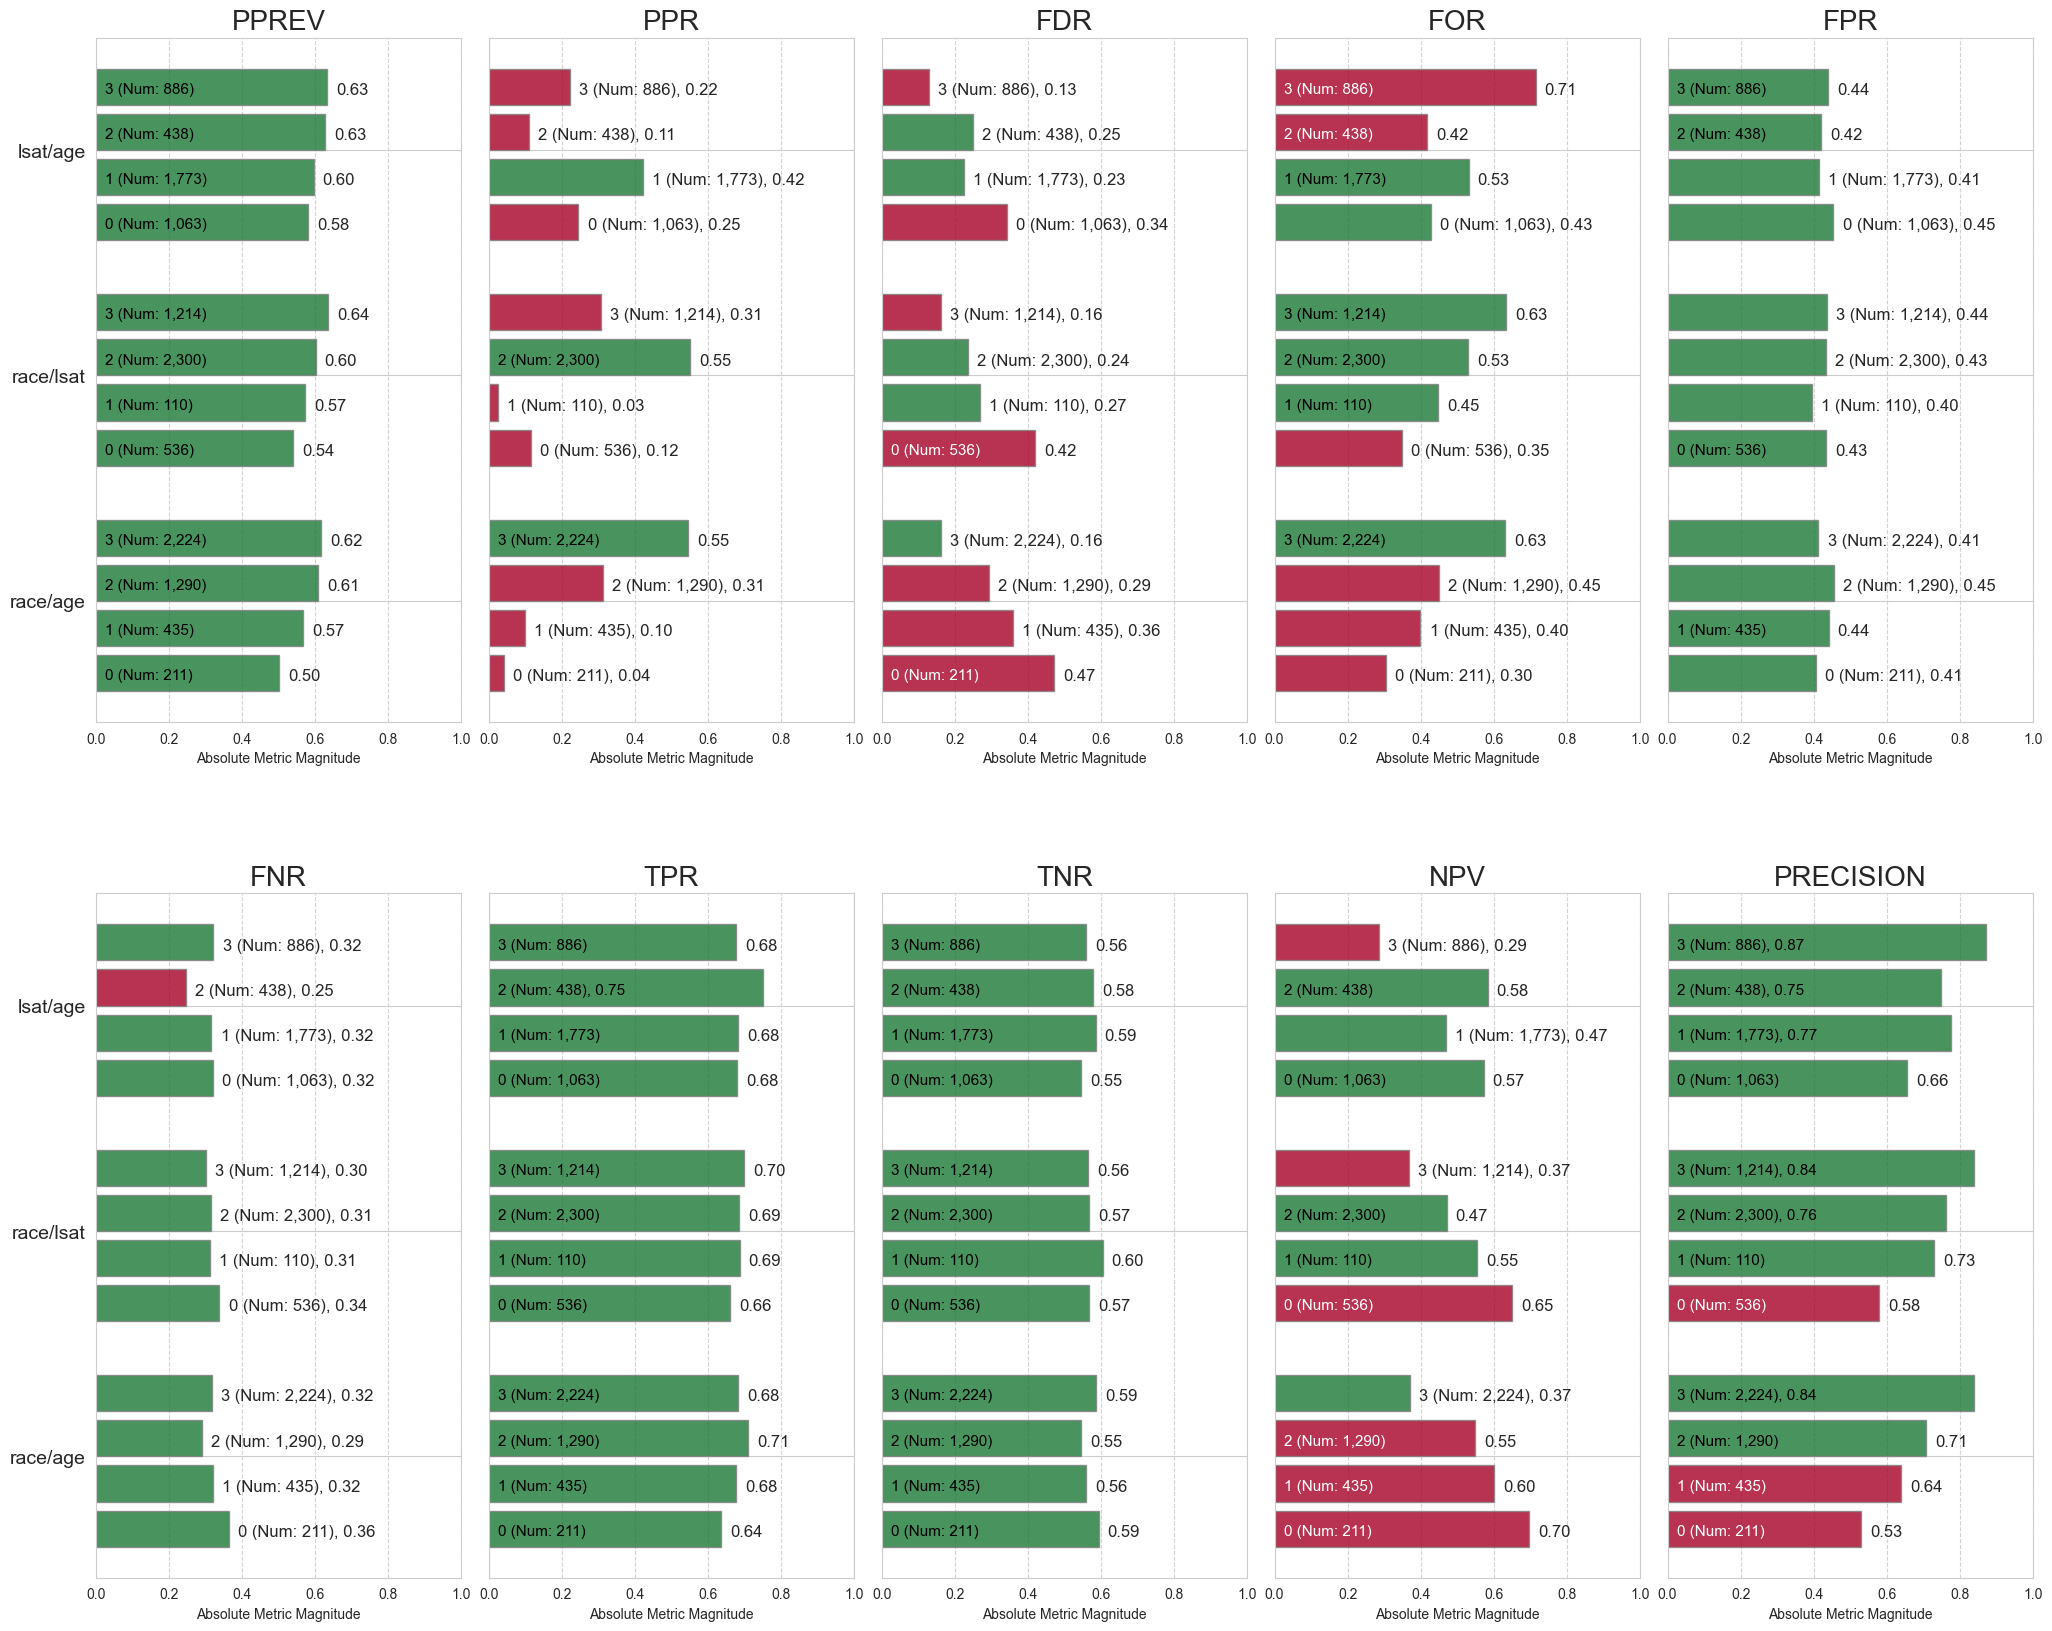

model_id score_threshold attribute_name  Statistical Parity  Impact Parity  \
0         0      binary 0/1       lsat/age               False           True   
1         0      binary 0/1       race/age               False           True   
2         0      binary 0/1      race/lsat               False           True   

   FDR Parity  FPR Parity  FOR Parity  FNR Parity  TPR Parity  TNR Parity  \
0       False        True       False       False        True        True   
1       False        True       False        True        True        True   
2       False        True       False        True        True        True   

   NPV Parity  Precision Parity  TypeI Parity  TypeII Parity  Equalized Odds  \
0       False              True         False          False            True   
1       False             False         False          False            True   
2       False             False         False          False            True   

   Unsupervised Fairness  Supervised Fairness  
0                  False                False  
1                  False                False  
2                  False                False

alt.VConcatChart(...)

alt.VConcatChart(...)

<Figure size 640x480 with 0 Axes>

In [106]:
df_test_fairlearn = post_process_group_threshold_fairlearn(df_num_int, protected_attributes_int, target)
plot_audit(df_test_int, protected_attributes_int)
plot_audit(df_test_fairlearn, protected_attributes_int)

---------- Model name:  RandomForest ----------

[INFO] 2024-10-15 13:51:46 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-10-15 13:51:46 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-10-15 13:51:46 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-10-15 13:51:46 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-10-15 13:51:46 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-10-15 13:51:46 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-10-15 13:51:46 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-10-15 13:51:46 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-10-15 13:51:46 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-10-15 13:51:46 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-10-15 13:51:46 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-10-15 13:51:46 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


Privileged groups:  [{'race/age': 3}]
Unprivileged groups:  [{'race/age': 0}, {'race/age': 1}, {'race/age': 2}]
Disparate Impact Ratio for race/age: 0.965
Normalized Disparate Impact Ratio for race/age: 0.965
Statistical Parity Difference for race/age: -0.032


Accuracy score test corrected:
0.6296


attribute_name attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0       race/age               0      0.52  0.92  0.24  0.19  0.54  0.76   
1       race/age               1      0.59  0.96  0.16  0.24  0.43  0.84   
2       race/age               2      0.64  0.93  0.20  0.35  0.36  0.80   
3       race/age               3      0.76  0.94  0.19  0.49  0.22  0.81   

    fnr   npv  precision   ppr  pprev  prev  
0  0.08  0.81       0.46  0.05   0.83  0.42  
1  0.04  0.76       0.57  0.11   0.90  0.54  
2  0.07  0.65       0.64  0.30   0.88  0.61  
3  0.06  0.51       0.78  0.54   0.91  0.76

Majority class for:  race/age  is: 3
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  for_disparity  \
0       race/age               0           2.48           1.37           0.39   
1       race/age               1           2.00           0.74           0.48   
2       race/age               2           1.66           1.19           0.70   
3       race/age               3           1.00           1.00           1.00   

   fpr_disparity  npv_disparity  ppr_disparity  pprev_disparity  \
0           0.94           1.60           0.09             0.91   
1           1.03           1.51           0.19             0.99   
2           0.98           1.29           0.56             0.96   
3           1.00           1.00           1.00             1.00   

   precision_disparity  ...  fdr_significance  fnr_significance  \
0                 0.59  ...              True              True   
1                 0.72  ...              True              True   
2                 0.82  ...              True              True   
3                 1.00  ...             False             False   

   for_significance  fpr_significance  npv_significance  ppr_significance  \
0              True              True              True              True   
1              True              True              True             False   
2              True              True              True              True   
3             False             False             False             False   

   pprev_significance  precision_significance  tnr_significance  \
0                True                    True              True   
1               False                    True              True   
2                True                    True              True   
3               False                   False             False   

   tpr_significance  
0              True  
1              True  
2              True  
3             False  

[4 rows x 24 columns]

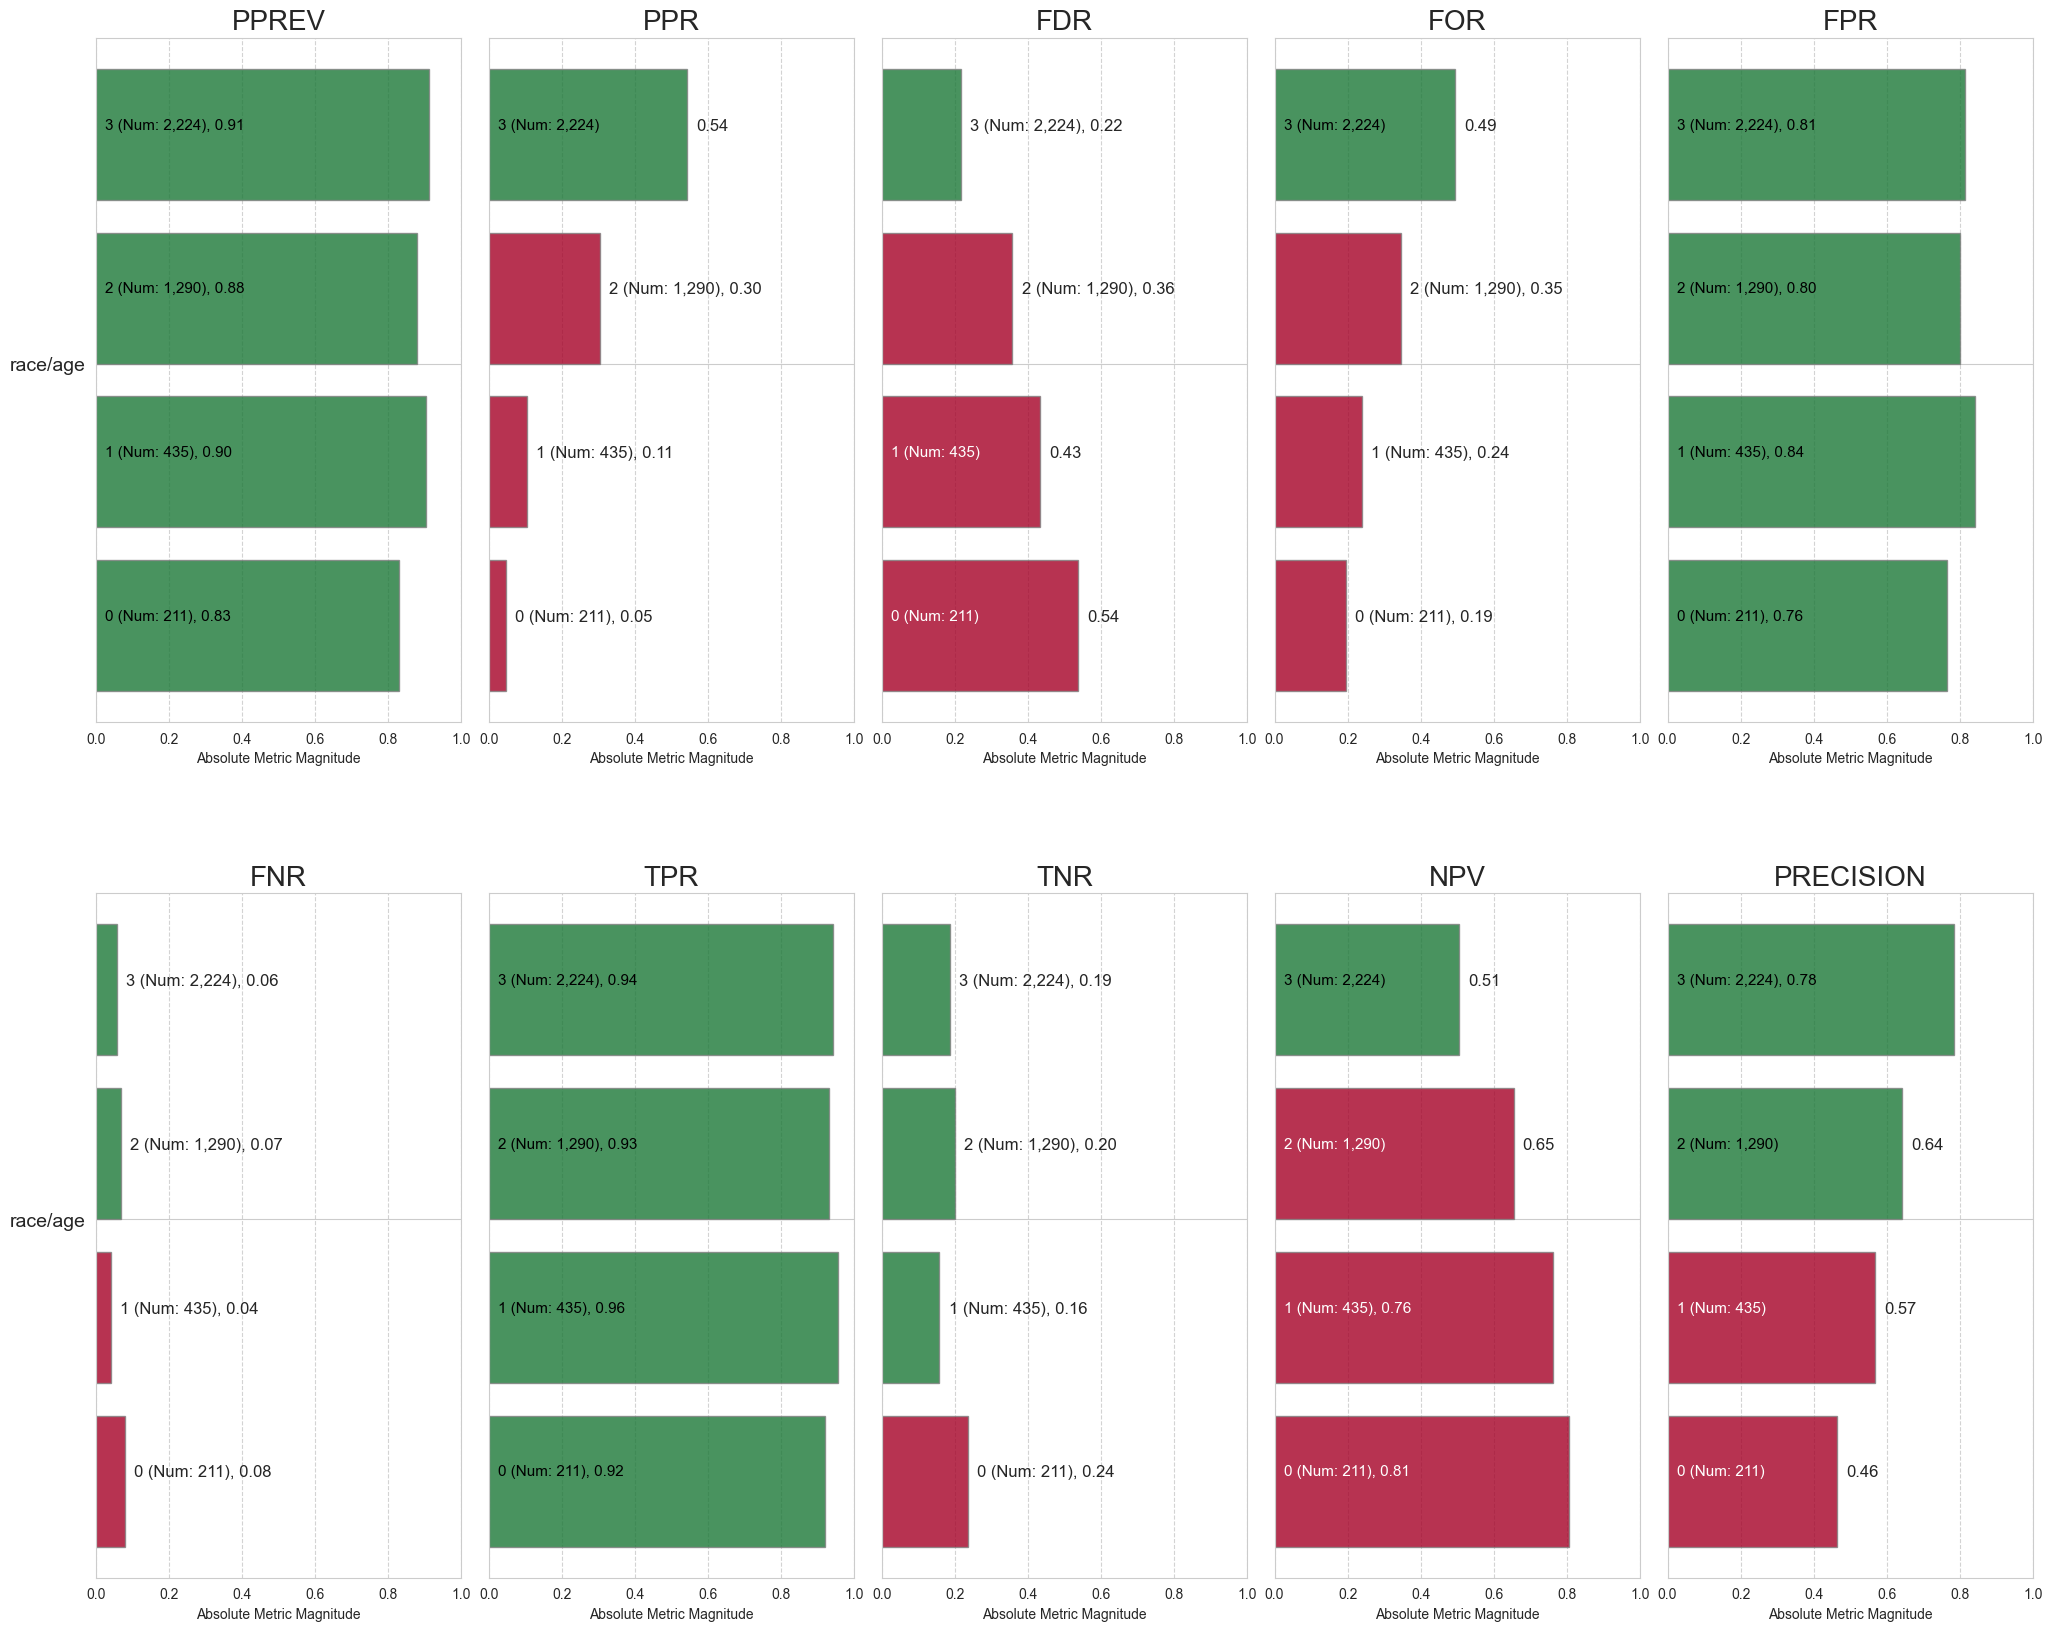

model_id score_threshold attribute_name  Statistical Parity  Impact Parity  \
0         0      binary 0/1       race/age               False           True   

   FDR Parity  FPR Parity  FOR Parity  FNR Parity  TPR Parity  TNR Parity  \
0       False        True       False       False        True       False   

   NPV Parity  Precision Parity  TypeI Parity  TypeII Parity  Equalized Odds  \
0       False             False         False          False            True   

   Unsupervised Fairness  Supervised Fairness  
0                  False                False

<Figure size 640x480 with 0 Axes>

In [107]:
df_test_aequitas = post_process_group_threshold_aequitas(df_num_int, 'race/age', target)
